#0.0 IMPORTS

In [ ]:
import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import scipy.stats         as stats

import warnings
import random

from IPython.display         import Image
from tabulate                import tabulate
from sklearn.preprocessing   import RobustScaler
from sklearn                 import metrics
from sklearn.cluster         import MiniBatchKMeans, MeanShift
from sklearn.cluster         import AgglomerativeClustering, Birch, KMeans
from sklearn.mixture         import GaussianMixture
from sklearn.metrics         import davies_bouldin_score,calinski_harabasz_score
from sklearn                 import metrics
from sklearn.ensemble        import RandomForestRegressor
from mpl_toolkits            import mplot3d
from IPython.core.display    import HTML
from kneed                   import KneeLocator
from sklearn.model_selection import GridSearchCV

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')

##0.1 Helper Functions

In [ ]:
def jupyter_settings():
  %matplotlib inline
  %pylab inline
  plt.style.use( 'bmh' )
  plt.rcParams['figure.figsize'] = [25, 12]
  plt.rcParams['font.size'] = 24
  display( HTML( '<style>.container { width:100% !important; }</style>') )
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  pd.set_option( 'display.expand_frame_repr', False )
  sns.set()


def silhouette_score(x,labels,model_name):
  s=metrics.silhouette_score(x,  labels) 
  return s


def model_performance(x,labels,model_name):

  sc=metrics.silhouette_score(x, labels)
  db=davies_bouldin_score(x, labels)
  ch=calinski_harabasz_score(x,  labels)
  df={'ModelName':[model_name],'Silhouette':[sc],'DaviesBouldin':[db],'CalinskiHarabasz':[ch]}
  df=pd.DataFrame(data=df)

  return df 



def NumericalCorrelation(numericos,data):

  columns=numericos.columns
  aux=data[columns]

  correlation=aux.corr(method='pearson')
  ax=sns.heatmap(correlation,annot=True);  
  ax.set_title('Correlação entre features numéricas',fontsize=14)

  return ax


def cramer_v(x,y):
  
  cm=pd.crosstab(x, y).to_numpy()
  n=cm.sum()
  r,k=cm.shape
  chi2=stats.chi2_contingency(cm)[0]
  chi2corr=max(0,chi2-(k-1)*(r-1)/(n-1))
  kcorr=k-(k-1)**2/(n-1)
  rcorr=r-(r-1)**2/(n-1)

  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))


def CategoricalCorrelation(data):

  #selecao
  a=data.select_dtypes(include='object')

  #lista 1 , todas correlacoes
  columns=a.columns
  lista=[]
  for i2 in range(0,len(columns)):
    for i in range(0,len(columns)):
      lista.append(cramer_v(a[columns[i2]],a[columns[i]]))

  #lista 2 , correlacoes por features
  lista2=[]
  n_features=len(columns)
  for i in range(0,n_features):

    a=n_features*i
    b=n_features*(i+1)

    lista2.append(lista[a:b])
  
  return lista2

In [ ]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


##0.2 Loading Data

In [ ]:
df_raw=pd.read_csv('/content/Ecommerce.csv',encoding = 'unicode_escape')
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.550,17850.000,United Kingdom,nan
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.390,17850.000,United Kingdom,nan
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.750,17850.000,United Kingdom,nan
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.390,17850.000,United Kingdom,nan
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.390,17850.000,United Kingdom,nan


# 1.0 PASSO 1 - DESCRIPTION OF THE DATA

In [ ]:
#Copia do dataframe
df1=df_raw.copy()

##1.1 Rename Columns

In [ ]:
names={ 'InvoiceNo':'NumeroFatura','StockCode':'CodigoStock','Description':'Produto',
        'Quantity':'Quantidade','InvoiceDate':'Data','UnitPrice':'Preco',
        'CustomerID':'IdCliente','Country':'Pais','Unnamed: 8':'Unnamed: 8'}

df1=df1.rename(columns=names)
df1.head(2)

,NumeroFatura,CodigoStock,Produto,Quantidade,Data,Preco,IdCliente,Pais,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.550,17850.000,United Kingdom,nan
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.390,17850.000,United Kingdom,nan


##1.2 Data Dimensions

In [ ]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de columnas: {}'.format(df1.shape[1]))

Número de linhas: 541909
Número de columnas: 9


##1.3 Data Types

In [ ]:
df1.dtypes

NumeroFatura     object
CodigoStock      object
Produto          object
Quantidade        int64
Data             object
Preco           float64
IdCliente       float64
Pais             object
Unnamed: 8      float64
dtype: object

##1.4 Check NA

In [ ]:
df1.isna().sum()

NumeroFatura         0
CodigoStock          0
Produto           1454
Quantidade           0
Data                 0
Preco                0
IdCliente       135080
Pais                 0
Unnamed: 8      541909
dtype: int64

##1.5 Fillout NA

In [ ]:
#Produto
df1=df1[df1['Produto'].isnull()==False]

#Unnamed: 8
df1=df1.drop(['Unnamed: 8'],axis=1)

#Quantidade
df1['Quantidade']=df1['Quantidade'].apply(lambda x: x*(-1) if x<=0 else x)

#Preco
df1['Preco']=df1['Preco'].apply(lambda x: x*(-1) if x<0 else x)

#IdCliente
df1=df1[df1['IdCliente'].isna()==False]

df1.isna().sum()

NumeroFatura    0
CodigoStock     0
Produto         0
Quantidade      0
Data            0
Preco           0
IdCliente       0
Pais            0
dtype: int64

##1.6 Change types

In [ ]:
#Data
df1['Data']=pd.to_datetime(df1['Data'])

#IdCliente
df1['IdCliente']=df1['IdCliente'].astype(str)

##1.7 Descriptive Statistical

In [ ]:
#num_attributes and cat_attributes
num_attributes=df1.select_dtypes(include=['int64','float64'])
cat_attributes=df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

###1.7.1 Numerical Attributes

In [ ]:
#Central tendency=mean,median
ct1=pd.DataFrame(num_attributes.apply(np.mean)).T
ct2=pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion=std,min,max,range,skew,kurtosis
d1=pd.DataFrame(num_attributes.apply(np.std)).T
d2=pd.DataFrame(num_attributes.apply(min)).T
d3=pd.DataFrame(num_attributes.apply(max)).T
d4=pd.DataFrame(num_attributes.apply(lambda x:x.mean()-x.min())).T
d5=pd.DataFrame(num_attributes.apply(lambda x:x.skew())).T
d6=pd.DataFrame(num_attributes.apply(lambda x:x.kurtosis())).T

#Concatenate
aux=pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()  
aux.columns=(['Attributes','Min','Max','Range','Mean','Median','Std','Skew','Kurtosis'])   
aux

,Attributes,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
0,Quantidade,1.000,80995.000,12.412,13.412,5.000,248.624,301.175,94357.660
1,Preco,0.000,38970.000,3.460,3.460,1.950,69.315,452.219,246924.543


In [ ]:
df1=df1[df1['Preco']>0]

###1.7.2 Categorical attributes


In [ ]:
cat_attributes.apply(lambda x:x.unique().shape[0])

NumeroFatura    22190
CodigoStock      3684
Produto          3896
IdCliente        4372
Pais               37
dtype: int64

#2.0 PASSO 2 - FEATURE ENGINEERING

In [ ]:
#copia do dataframe
df2=df1.copy()

##2.1 Mapa mental de Hipoteses

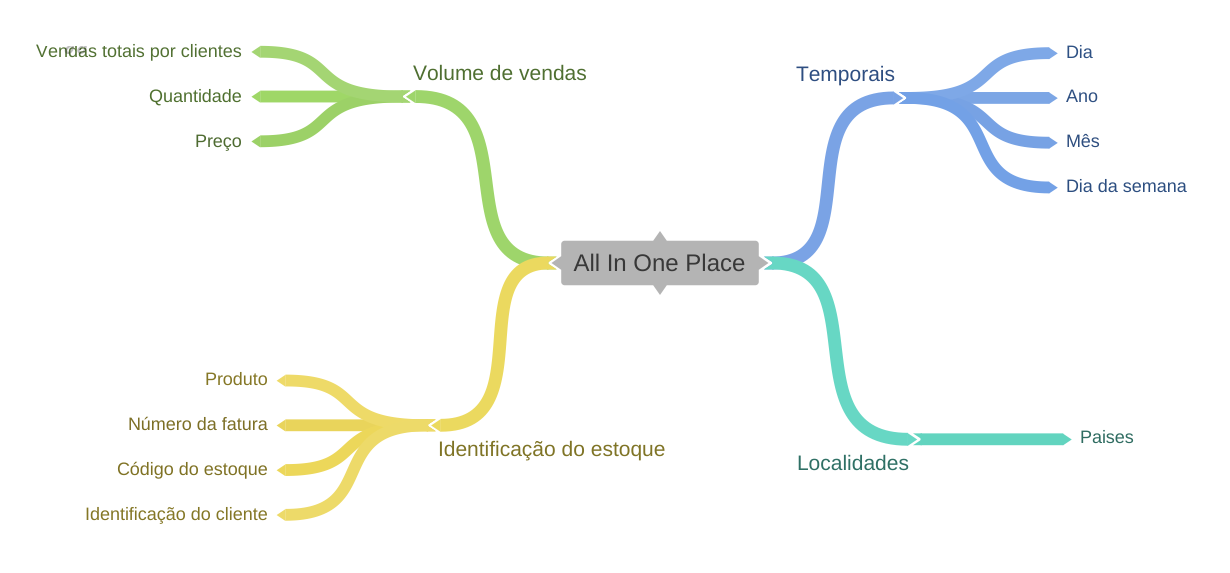

In [ ]:
Image('/content/mindmap.png')

##2.2 Criação das hipoteses

### 2.1.1 Hipoteses Temporais

**1.** As vendas aumentam ao longo dos anos

**2.** As vendas aumentam nos finais de ano (Setembro).

 **3.** As vendas aumentam no início do mês

 **4.** As vendas aumentam nos sabádos.

**5.** Clientes mais antigos tendem a comprar mais.

### 2.1.2 Hipoteses Localidades

**1.** O maior volume de compras está entre as regiões do Reino Unido, França  e Alemanha.

### 2.1.3 Hipoteses Volumes de vendas

**1.** Quanto menor o preço dos produtos maior e a quantidade vendidada

##2.3 Lista final de hipoteses

**H1-**As vendas aumentam ao longo dos anos.

**H2-**As vendas aumentam nos finais de ano (Setembro).

**H3-**As vendas aumentam no início do mês.

**H4-**As vendas aumentam nos sabádos.

**H5-**Clientes mais antigos tendem a comprar mais.

**H6-**O maior volume de compras está entre as regiões do Reino Unido, França  e Alemanha.

**H7-**Quanto menor o preço dos produtos maior e a quantidade vendidada.

##2.3 Feature Engineering

In [ ]:
#Ano
df2['Ano']=df2['Data'].dt.year

#Mes
df2['Mes']=df2['Data'].dt.month

#Dia
df2['Dia']=df2['Data'].dt.day

#DiaDaSemana
df2['DiaDaSemana']=df2['Data'].dt.dayofweek

#ValorDaCompra
df2['ValorDaCompra']=df2['Quantidade']*df2['Preco']
df2=df2[df2['ValorDaCompra']<20000]

#3.0. PASSO 3 - EXPLORATORY DATA ANALYSIS

In [ ]:
#copia do dataframe
df3=df2.copy()

## 3.1 Univariate Analysis

###3.1.1. Response Variable

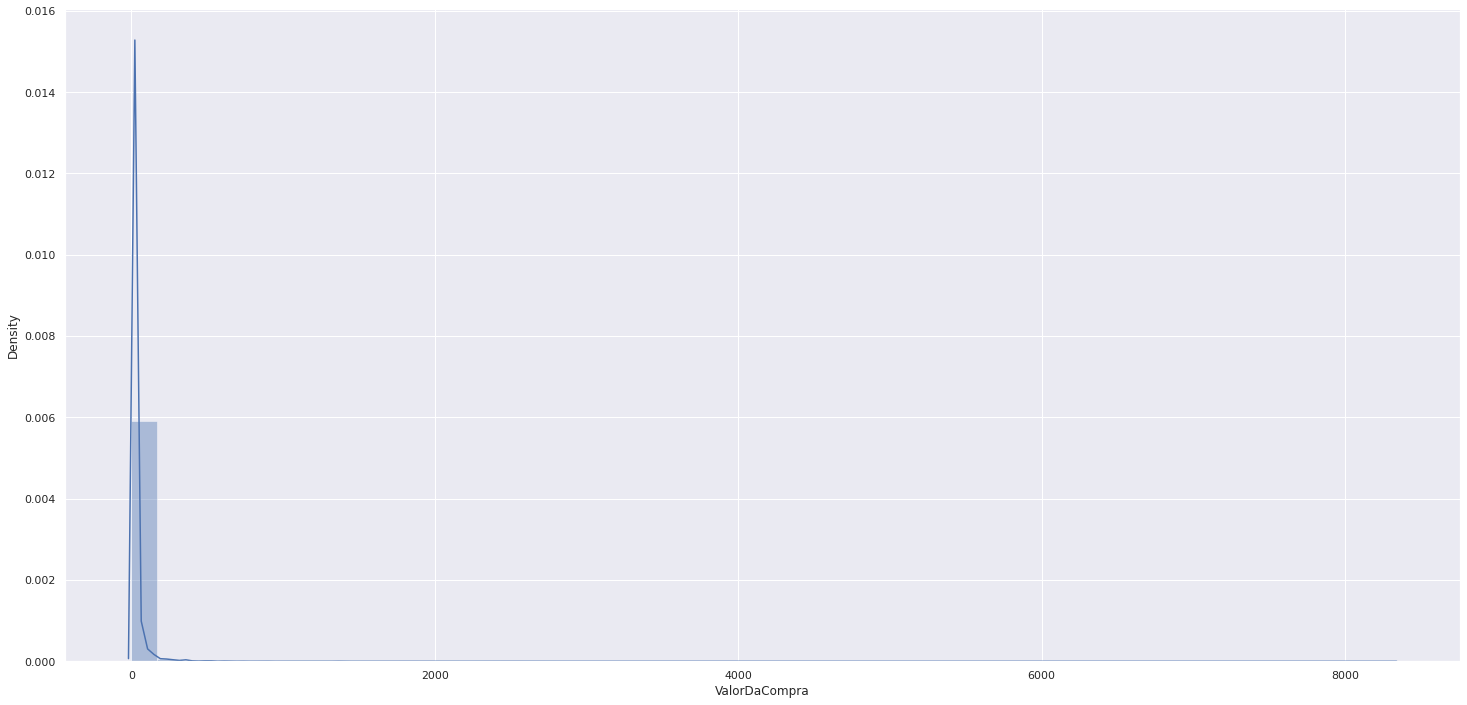

In [ ]:
sns.distplot(df3['ValorDaCompra'])

###3.1.2. Numerical Variable

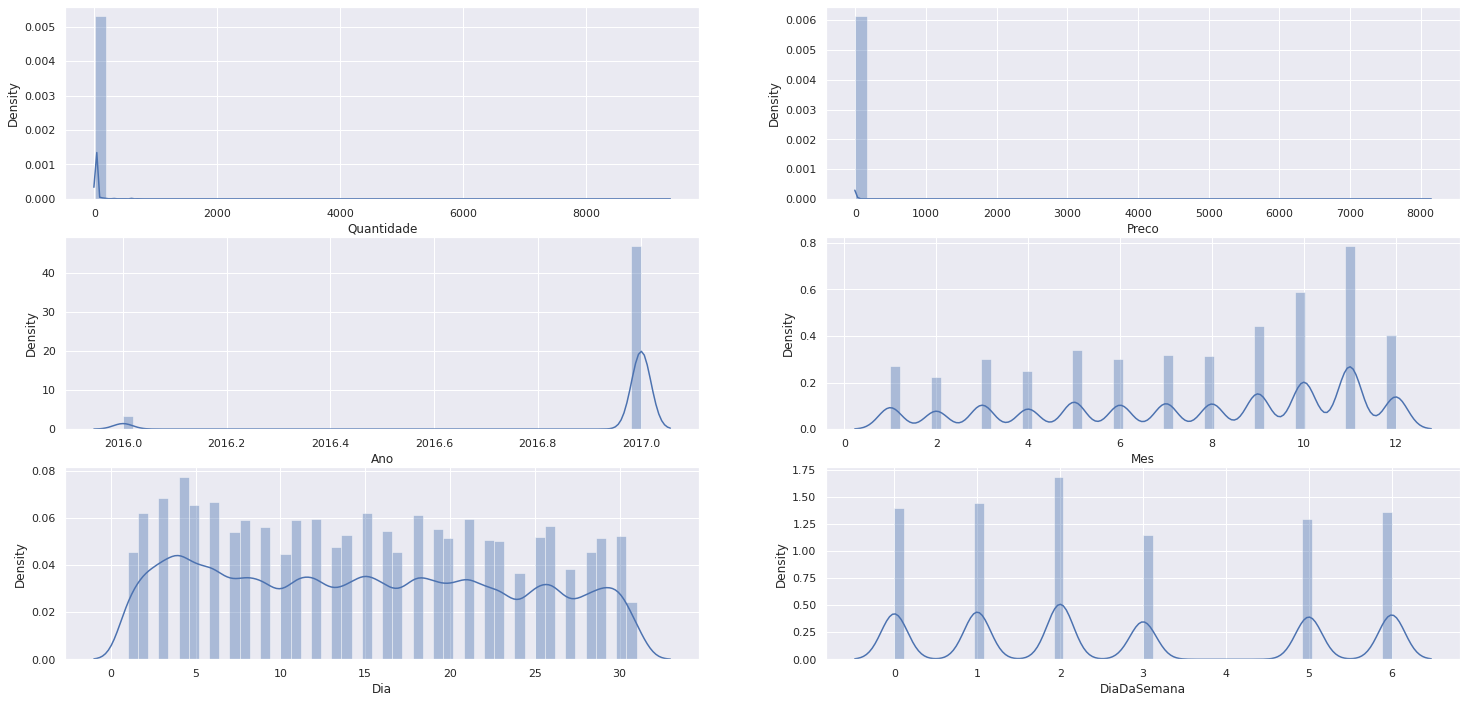

In [ ]:
#Quantidade
plt.subplot(3,2,1)
ax=sns.distplot(df3['Quantidade'])

#Preco
plt.subplot(3,2,2)
ax=sns.distplot(df3['Preco'])

#Ano
plt.subplot(3,2,3)
ax=sns.distplot(df3['Ano'])

#Mes
plt.subplot(3,2,4)
ax=sns.distplot(df3['Mes'])

#Dia
plt.subplot(3,2,5)
ax=sns.distplot(df3['Dia'])

#DiaDaSemana
plt.subplot(3,2,6)
ax=sns.distplot(df3['DiaDaSemana'])

###3.1.3. Categorical Variable

Text(0.5, 1.0, 'Codigo do estoque mais utilizado')

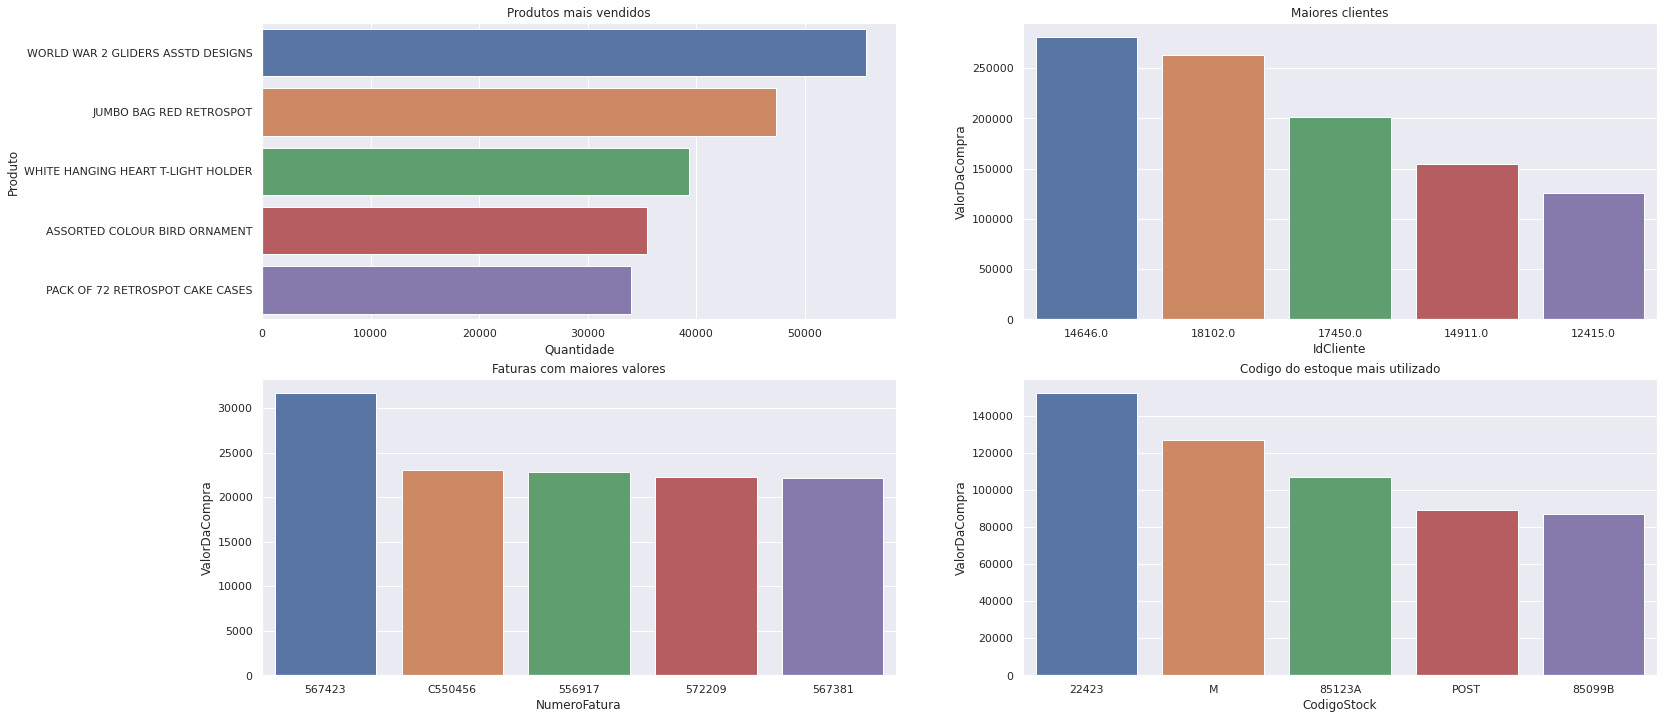

In [ ]:
#Produto
plt.subplot(2,2,1)
aux=pd.DataFrame(data=df3.groupby('Produto')['Quantidade'].sum(),columns=['Quantidade']).sort_values('Quantidade',ascending=False).head(5)
ax=sns.barplot(y=aux.index,x='Quantidade',data=aux)
ax.set_title('Produtos mais vendidos')

#IdCliente
plt.subplot(2,2,2)
aux2=pd.DataFrame(data=df3.groupby('IdCliente')['ValorDaCompra'].sum(),columns=['ValorDaCompra']).sort_values('ValorDaCompra',ascending=False).head(5)
ax=sns.barplot(x=aux2.index,y='ValorDaCompra',data=aux2)
ax.set_title('Maiores clientes')

#NumeroFatura
plt.subplot(2,2,3)
aux3=pd.DataFrame(data=df3.groupby('NumeroFatura')['ValorDaCompra'].sum(),columns=['ValorDaCompra']).sort_values('ValorDaCompra',ascending=False).head(5)
ax=sns.barplot(x=aux3.index,y='ValorDaCompra',data=aux3)
ax.set_title('Faturas com maiores valores')

#CodigoStock
plt.subplot(2,2,4)
aux4=pd.DataFrame(data=df3.groupby('CodigoStock')['ValorDaCompra'].sum(),columns=['ValorDaCompra']).sort_values('ValorDaCompra',ascending=False).head(5)
ax=sns.barplot(x=aux4.index,y='ValorDaCompra',data=aux4)
ax.set_title('Codigo do estoque mais utilizado')

## 3.2 Bivariate Analysis

### ***H1***.As vendas aumentam ao longo dos anos.(TRUE)  


Text(0.5, 1.0, 'Vendas nos meses de Novembro e Dezembro')

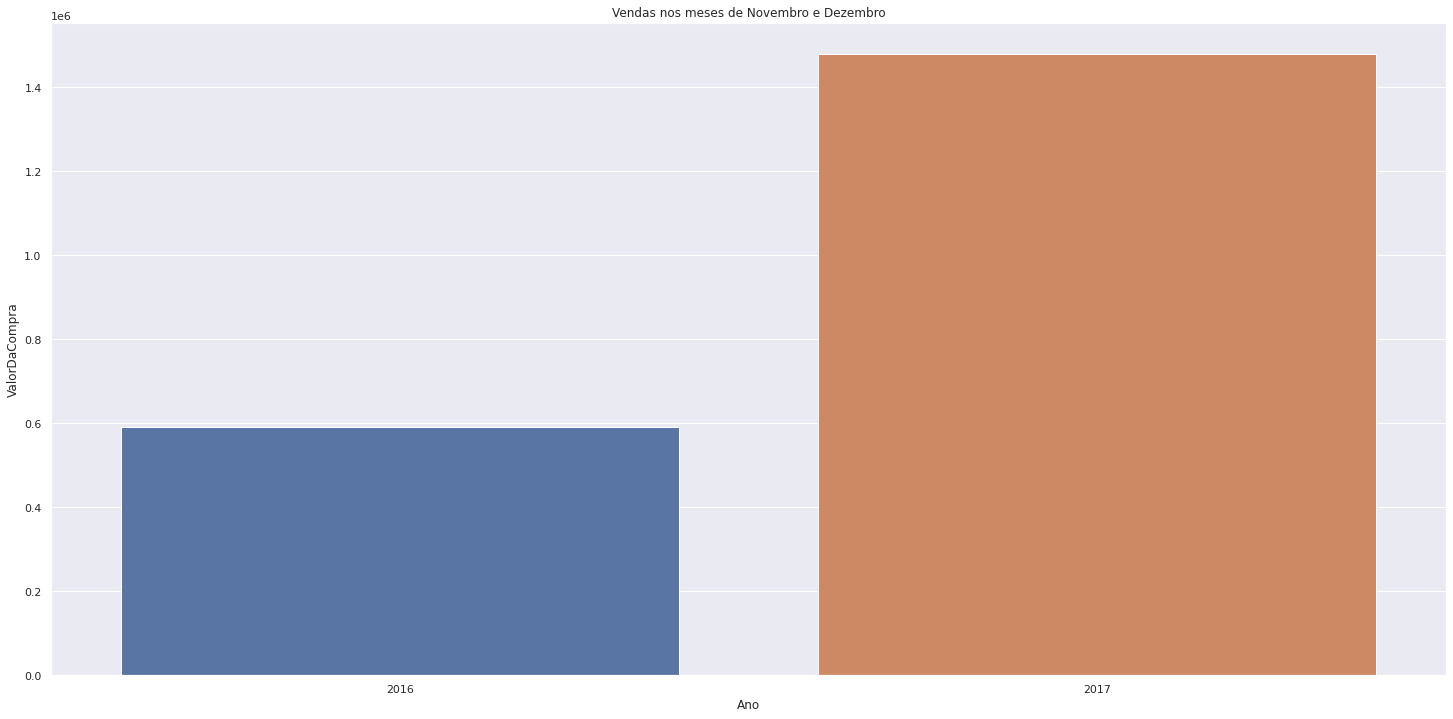

In [ ]:
aux=df3[['Mes','Ano','ValorDaCompra']].groupby(['Ano','Mes']).sum().reset_index()
aux=aux[(aux['Mes']==11) | (aux['Mes']==12)]
aux=aux.groupby('Ano').sum().reset_index()

ax=sns.barplot(x='Ano',y='ValorDaCompra',data=aux)
ax.set_title('Vendas nos meses de Novembro e Dezembro')

### ***H2***. As vendas aumentam nos finais de ano (Setembro). (TRUE)

Text(0.5, 1.0, 'Vendas ao longo dos meses de 2017')

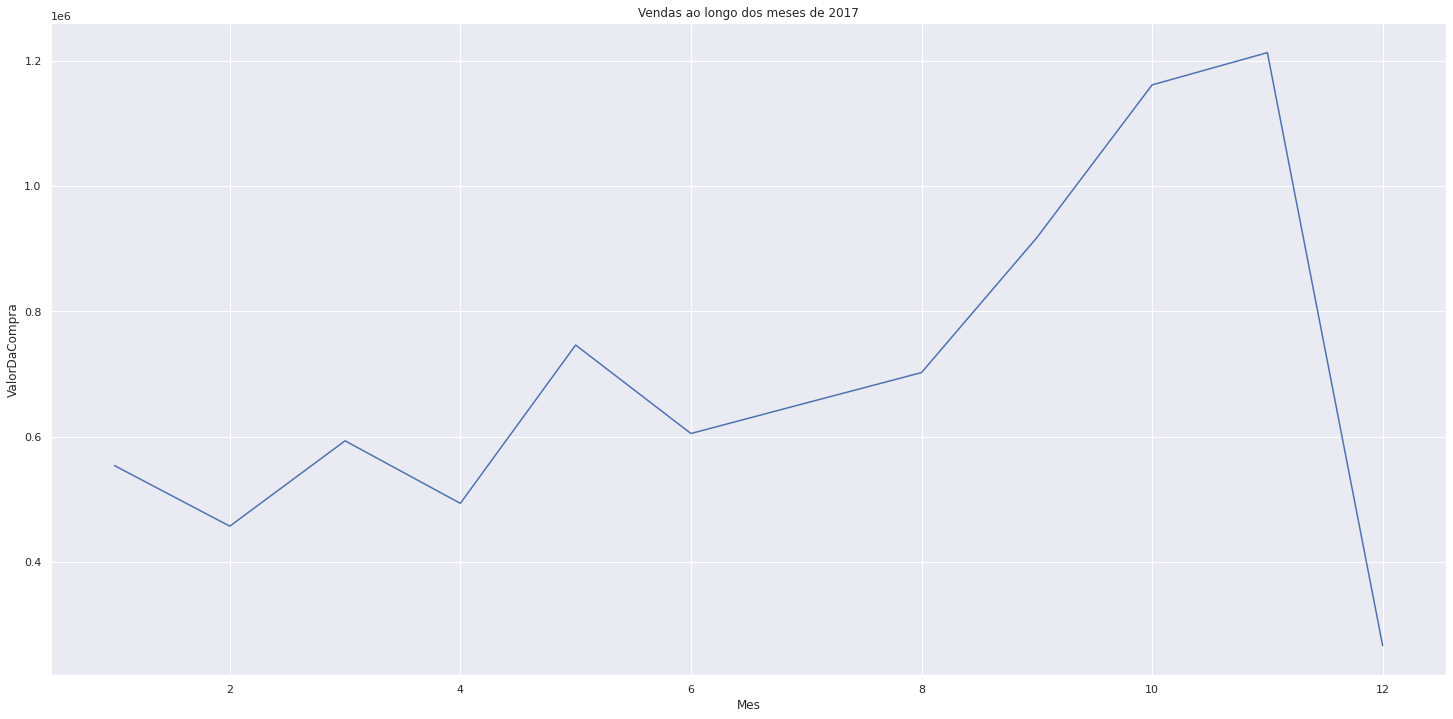

In [ ]:
aux=df3[df3['Ano']==2017]
aux=aux.groupby('Mes').sum().reset_index()
ax=sns.lineplot(x='Mes',y='ValorDaCompra',data=aux)
ax.set_title('Vendas ao longo dos meses de 2017')

### ***H3***. As vendas aumentam no início do mês.(TRUE)

Text(0.5, 1.0, 'Soma de vendas por dia ')

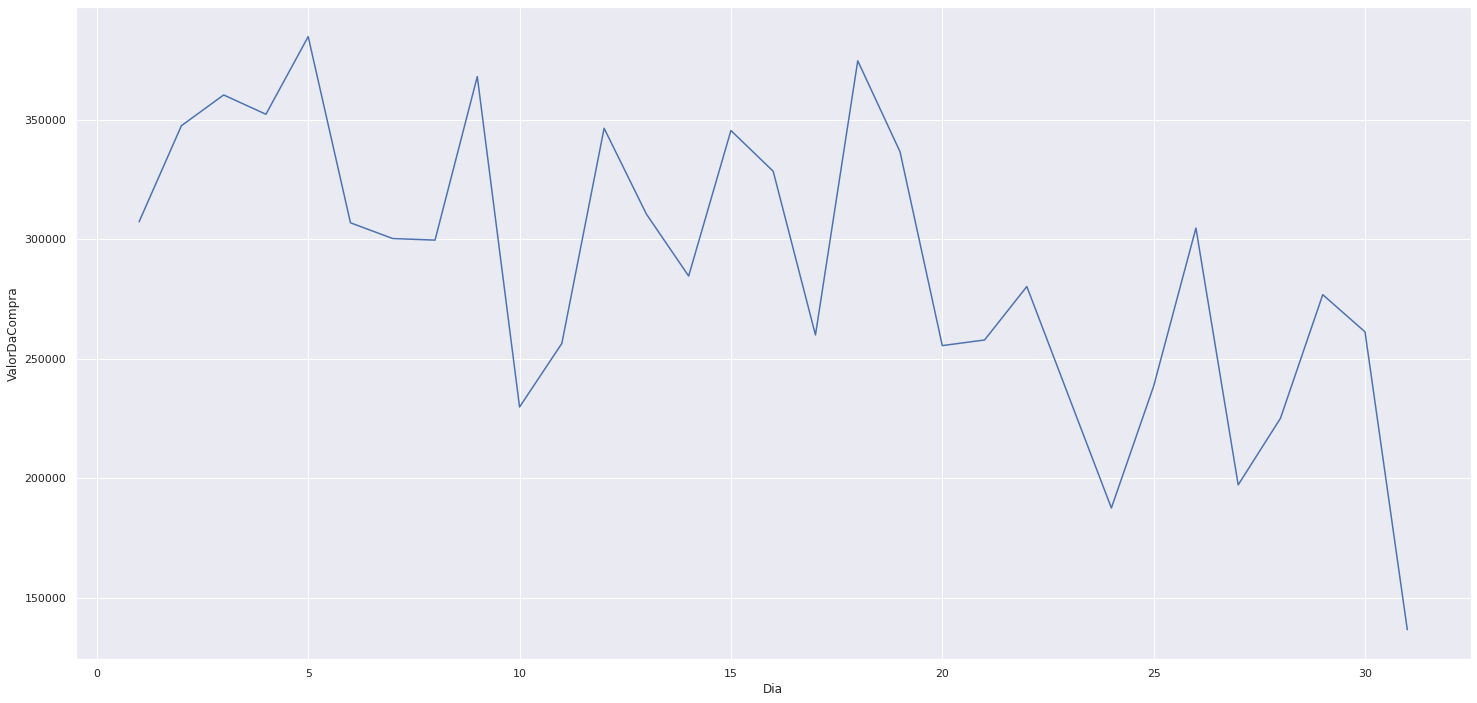

In [ ]:
aux=df3.groupby('Dia').sum().reset_index()

sns.lineplot(x='Dia',y='ValorDaCompra',data=aux)
ax.set_title('Soma de vendas por dia ')

### ***H4***. As vendas aumentam nos sabádos.(FALSE)


Text(0.5, 1.0, 'Vendas por dia da semana')

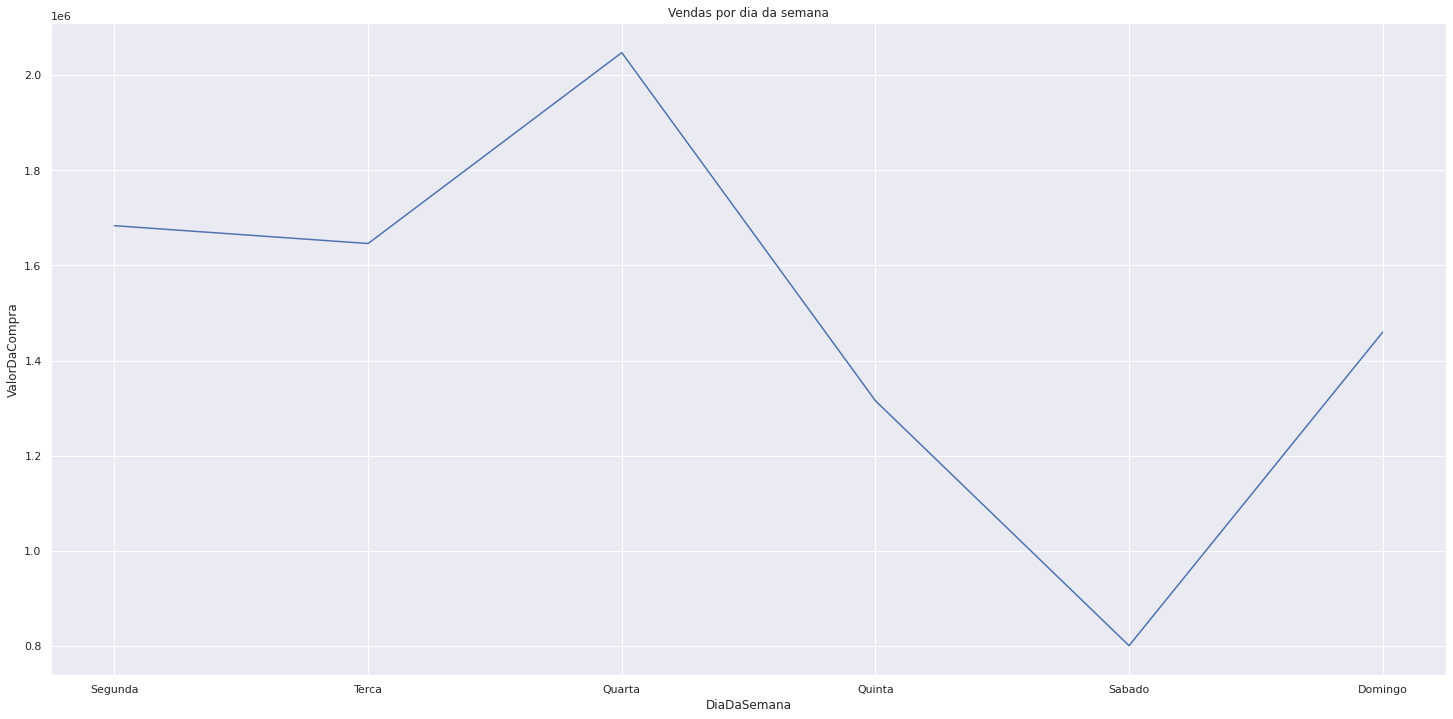

In [ ]:
aux=df3[['DiaDaSemana','ValorDaCompra']].groupby('DiaDaSemana').sum().reset_index()
aux['DiaDaSemana']=aux['DiaDaSemana'].apply(lambda x : 'Segunda' if x==0 else 
                                                       'Terca'   if x==1 else 
                                                       'Quarta'  if x==2 else
                                                       'Quinta'  if x==3 else
                                                       'Sexta'   if x==4 else
                                                       'Sabado'  if x==5 else
                                                       'Domingo' if x==6 else x)

ax=sns.lineplot(x='DiaDaSemana',y='ValorDaCompra',data=aux)
ax.set_title('Vendas por dia da semana')

### ***H5***.Clientes mais antigos tendem a comprar mais.(FALSE)


Text(0.5, 1.0, 'Valor da compra no tempo')

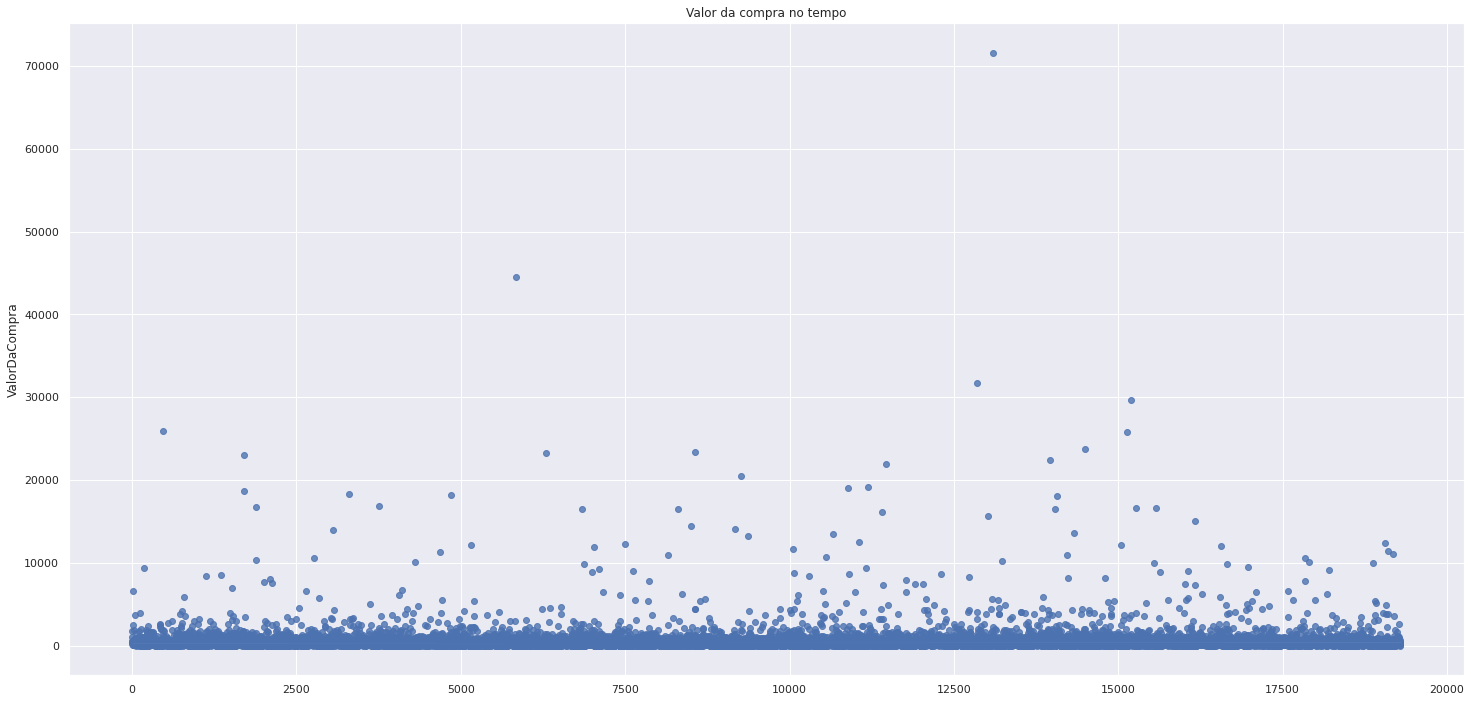

In [ ]:
aux=df3[['IdCliente','Data','ValorDaCompra']].groupby(['IdCliente','Data']).sum().reset_index()
aux=aux.sort_values('Data',ascending=True).reset_index()

ax=sns.regplot(x=aux.index,y='ValorDaCompra',data=aux)
ax.set_title('Valor da compra no tempo')

### ***H6***.O maior volume de compras está entre as regiões do Reino Unido, França  e Alemanha.(TRUE)


Text(0.5, 1.0, 'Maiores compradores por paises')

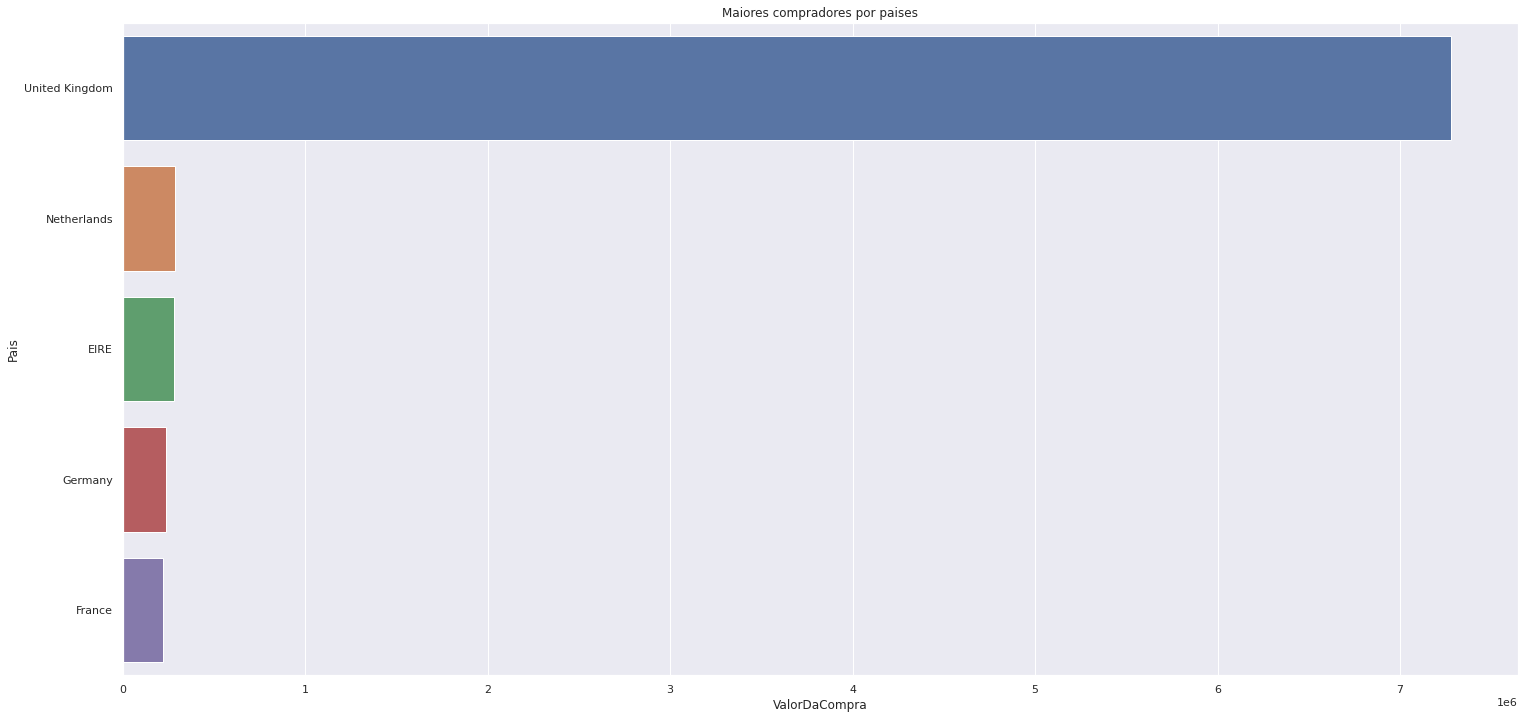

In [ ]:
aux=df3[['Pais','ValorDaCompra']].groupby('Pais').sum().reset_index().sort_values('ValorDaCompra',ascending=False).head(5)

ax=sns.barplot(x='ValorDaCompra',y='Pais',data=aux)
ax.set_title('Maiores compradores por paises')

### ***H7***.Quanto menor o preço dos produtos maior é a quantidade vendidada. (FALSE)

Text(0.5, 1.0, 'Preco x Quantidade vendida')

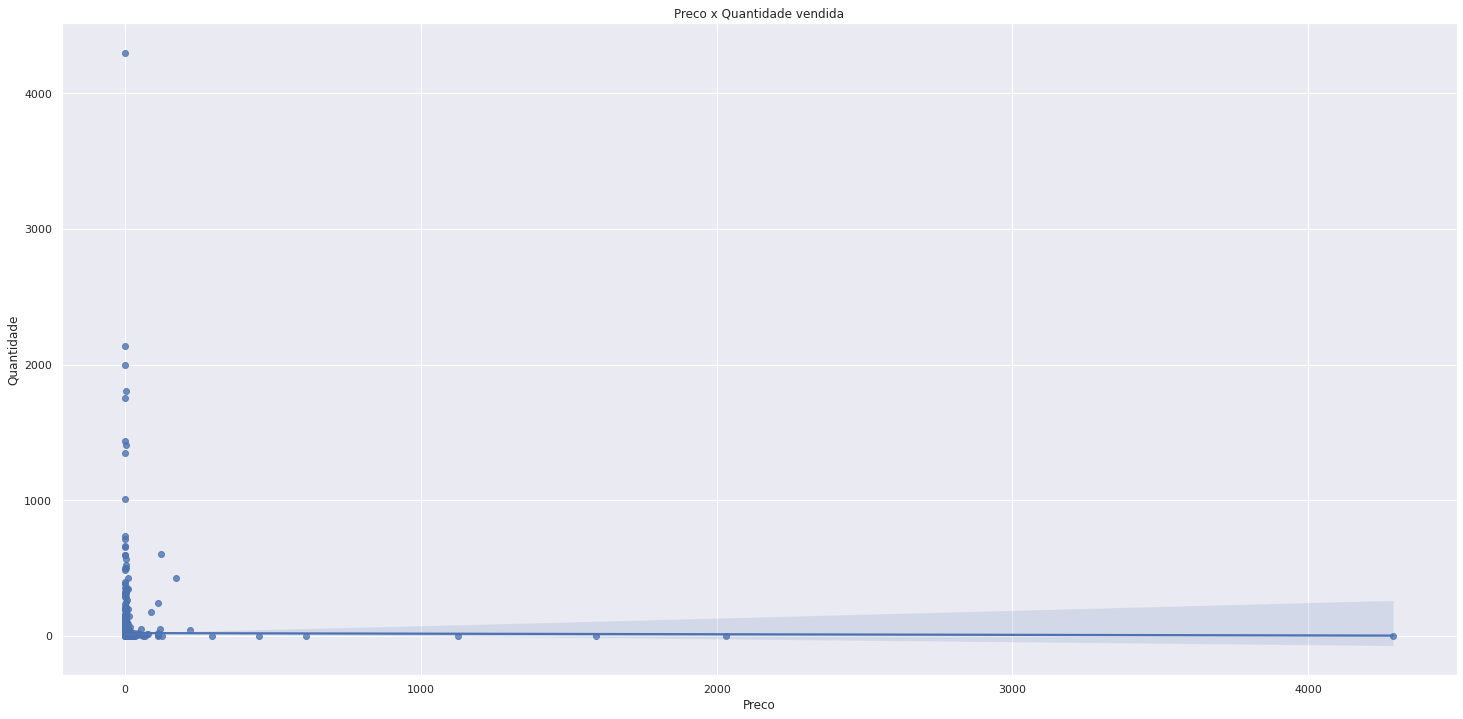

In [ ]:
aux=df3[['IdCliente','Preco','Quantidade']].groupby(['IdCliente']).mean().reset_index()
ax=sns.regplot(x='Preco',y='Quantidade',data=aux)
ax.set_title('Preco x Quantidade vendida')

### 3.2.1 Summary of hypotheses

In [ ]:
tab=[['Hipoteses','conclusao','Relevancia'],
     ['H1','True','Media'],
     ['H2','True','Alta'],
     ['H3','True','Media'],
     ['H4','False','Baixa'],
     ['H5','False','Baixa'],
     ['H6','True','Baixa'],
     ['H7','False','Baixa'],]

print(tabulate(tab,headers='firstrow'))

Hipoteses    conclusao    Relevancia
-----------  -----------  ------------
H1           True         Media
H2           True         Alta
H3           True         Media
H4           False        Baixa
H5           False        Baixa
H6           True         Baixa
H7           False        Baixa


## 3.3 Multivariate Analysis

###3.3.1. Numerical Atributes

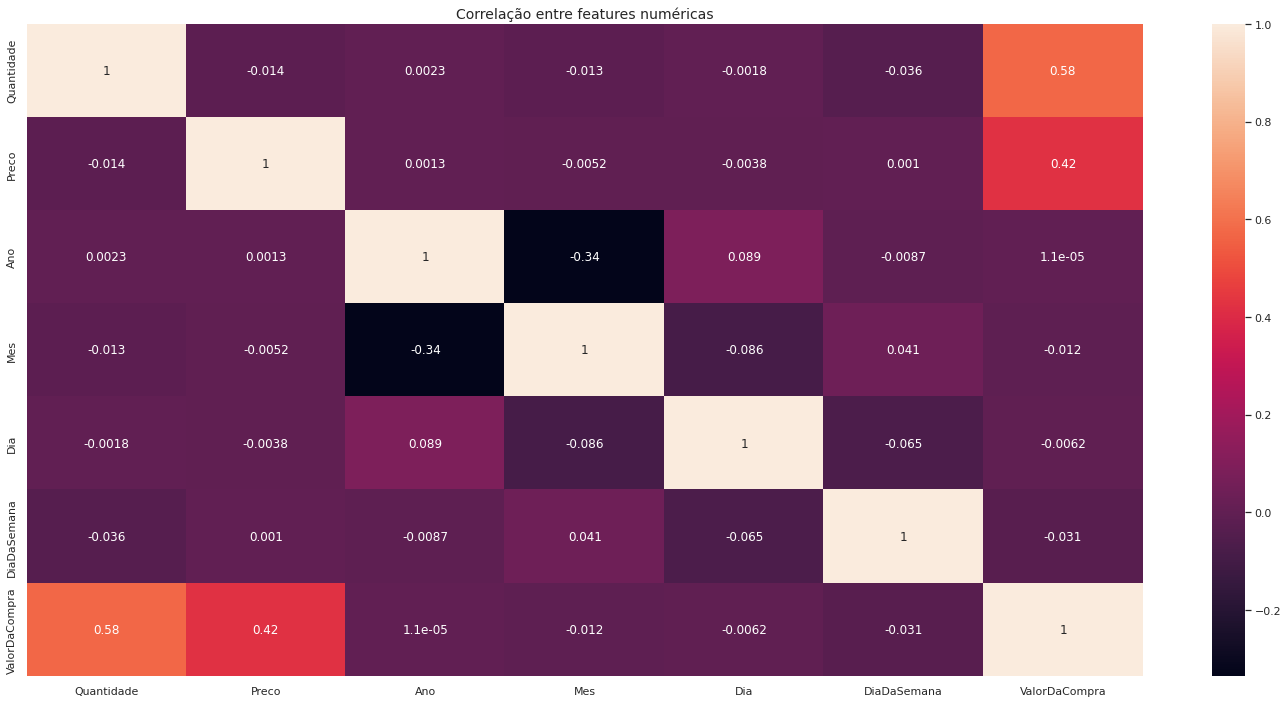

In [ ]:
NumericalCorrelation(df3[['Quantidade','Preco','Ano','Mes','Dia','DiaDaSemana','ValorDaCompra']],df3)

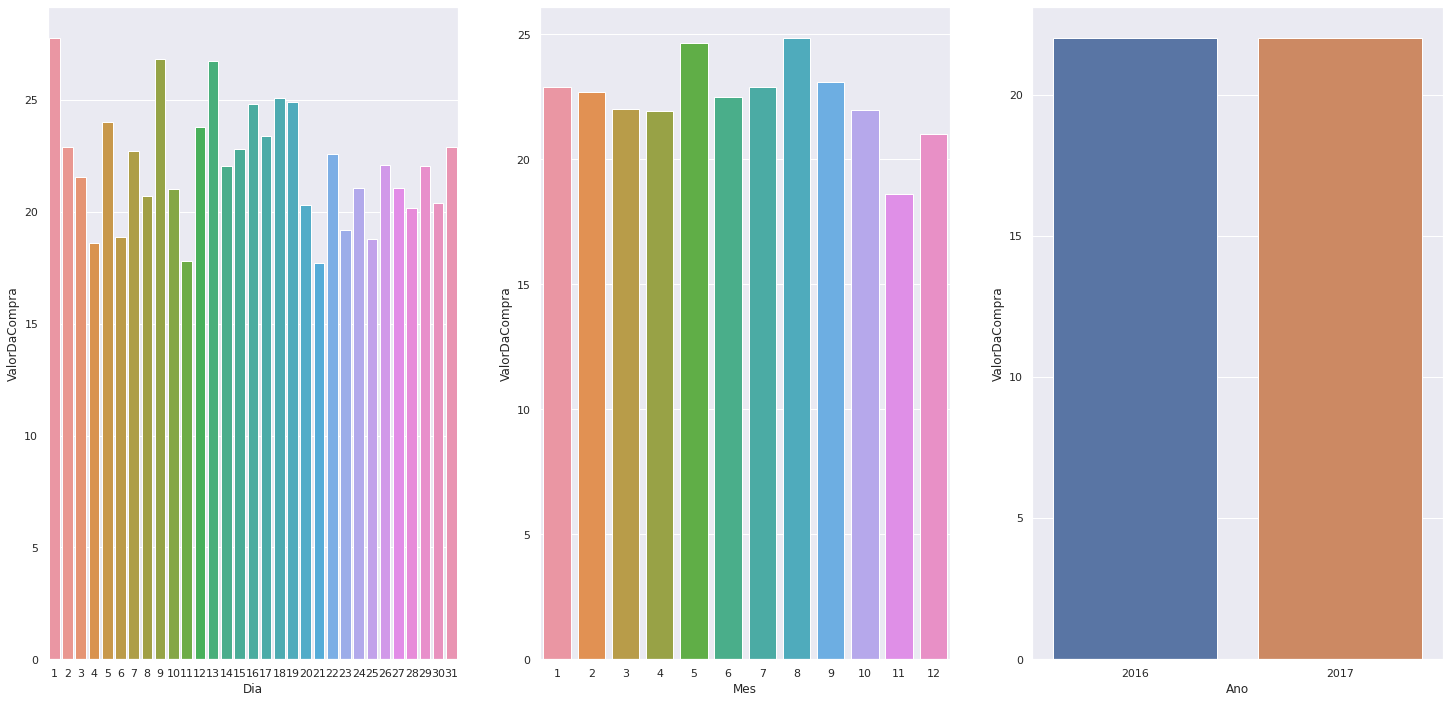

In [ ]:
#ValorDaCompra x temporais
plt.subplot(1,3,1)
aux=df3[['ValorDaCompra','Dia']].groupby(['Dia']).mean().reset_index()
ax=sns.barplot(x='Dia',y='ValorDaCompra',data=aux)

plt.subplot(1,3,2)
aux=df3[['ValorDaCompra','Mes']].groupby(['Mes']).mean().reset_index()
ax=sns.barplot(x='Mes',y='ValorDaCompra',data=aux)

plt.subplot(1,3,3)
aux=df3[['ValorDaCompra','Ano']].groupby(['Ano']).mean().reset_index()
ax=sns.barplot(x='Ano',y='ValorDaCompra',data=aux)

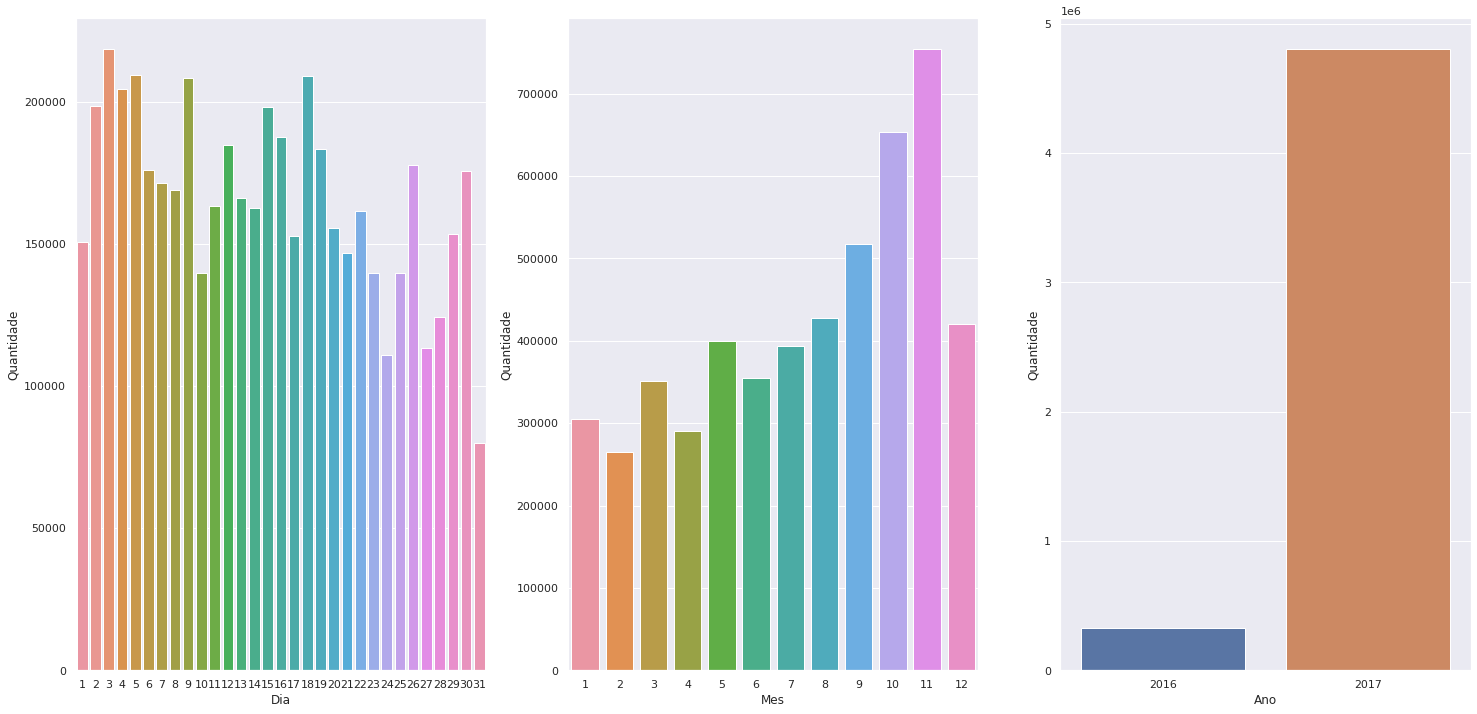

In [ ]:
#Quantidade x temporais
plt.subplot(1,3,1)
aux=df3[['Quantidade','Dia']].groupby(['Dia']).sum().reset_index()
ax=sns.barplot(x='Dia',y='Quantidade',data=aux)

plt.subplot(1,3,2)
aux=df3[['Quantidade','Mes']].groupby(['Mes']).sum().reset_index()
ax=sns.barplot(x='Mes',y='Quantidade',data=aux)

plt.subplot(1,3,3)
aux=df3[['Quantidade','Ano']].groupby(['Ano']).sum().reset_index()
ax=sns.barplot(x='Ano',y='Quantidade',data=aux)

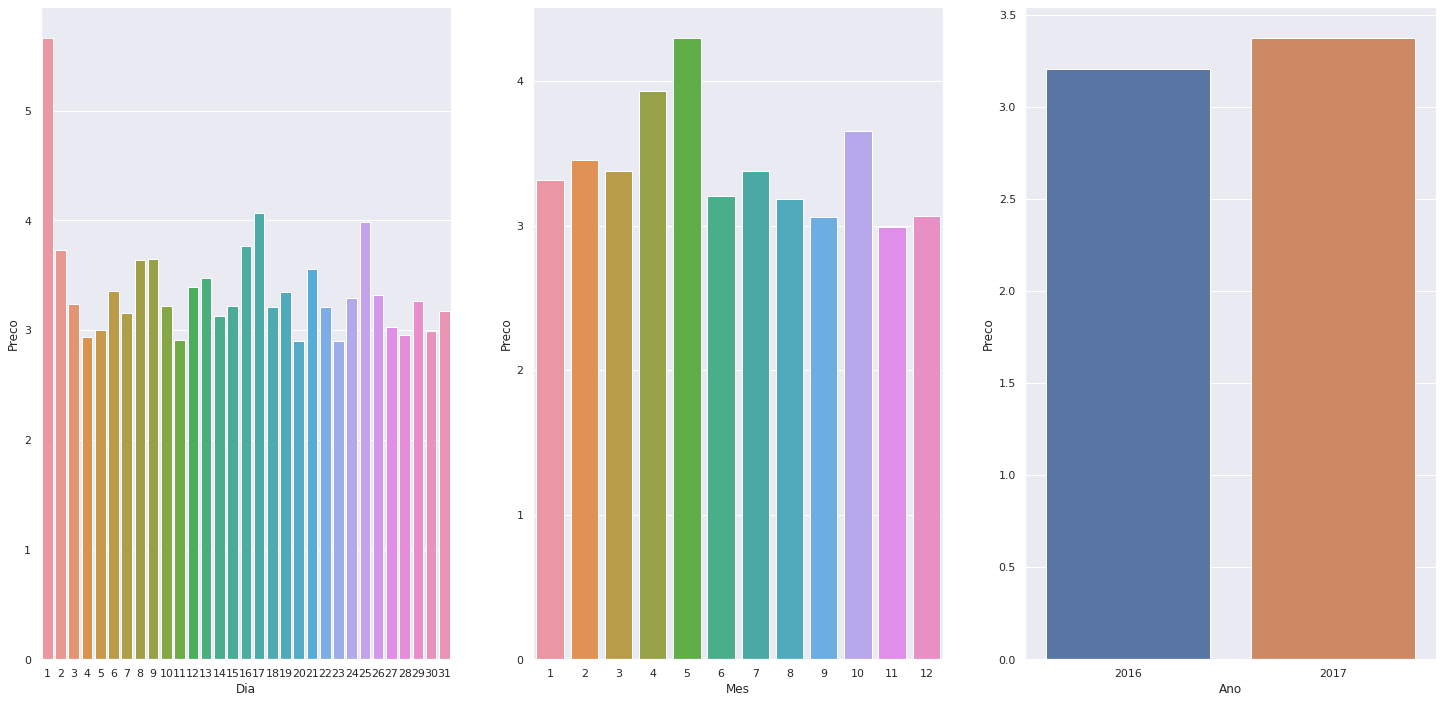

In [ ]:
#Preco x temporais
plt.subplot(1,3,1)
aux=df3[['Preco','Dia']].groupby(['Dia']).mean().reset_index()
ax=sns.barplot(x='Dia',y='Preco',data=aux)

plt.subplot(1,3,2)
aux=df3[['Preco','Mes']].groupby(['Mes']).mean().reset_index()
ax=sns.barplot(x='Mes',y='Preco',data=aux)

plt.subplot(1,3,3)
aux=df3[['Preco','Ano']].groupby(['Ano']).mean().reset_index()
ax=sns.barplot(x='Ano',y='Preco',data=aux)

###3.3.2. Categorical Atributes

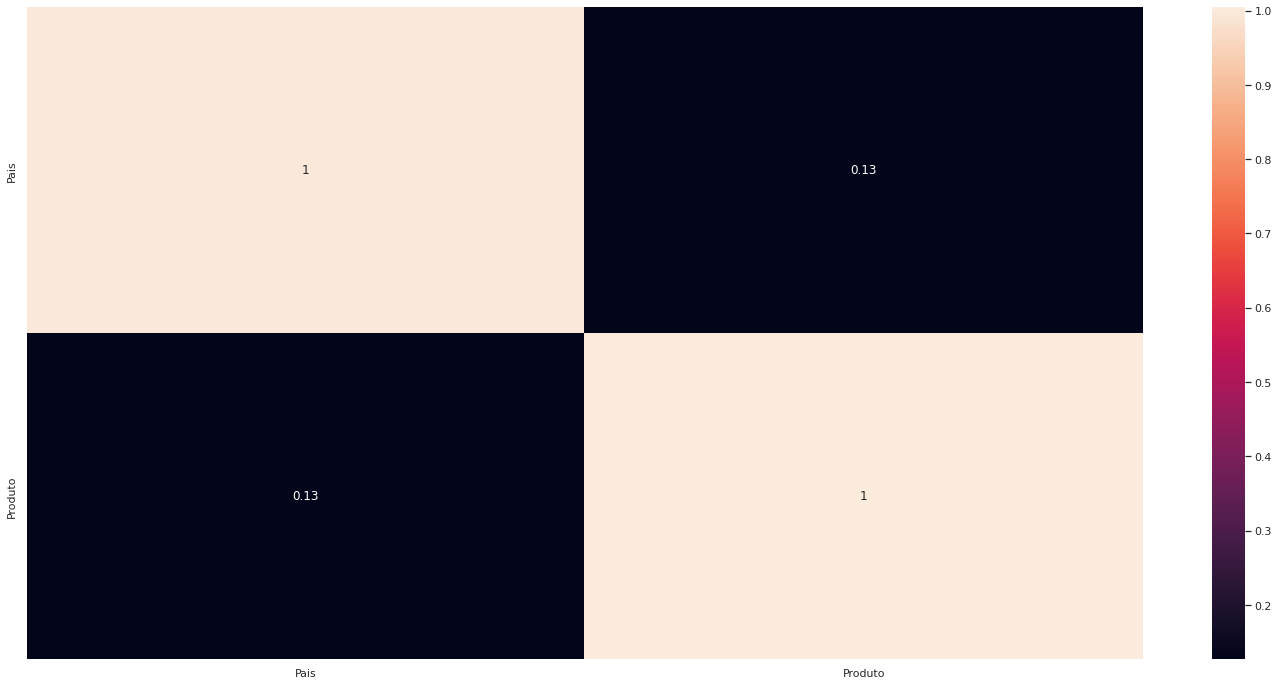

In [ ]:
lista=CategoricalCorrelation(df3[['Pais','Produto']])

d=pd.DataFrame({'Pais':                           lista[0],
                'Produto':                        lista[1]                             
                })

d=d.set_index(d.columns)

sns.heatmap(d,annot=True)

#4.0. PASSO 4 - DATA PREPARATION

In [ ]:
#copia do dataframe
df4=df3.copy()

#Preparando o dataframe para a realização do agrupamento
df4=df4[['IdCliente','ValorDaCompra']].groupby('IdCliente').agg({'ValorDaCompra': ['mean','sum','max']})
df4=pd.DataFrame(df4)
df4.columns=['Mean', 'Sum','Max']
df4=df4.reset_index()
df4.head()

,IdCliente,Mean,Sum,Max
0,12347.0,23.681,4310.000,249.600
1,12348.0,57.975,1797.240,240.000
2,12349.0,24.076,1757.550,300.000
3,12350.0,19.671,334.400,40.000
4,12352.0,36.491,3466.670,376.500


##4.2. Rescaling

In [ ]:
rs=RobustScaler()

#Mean
df4['Mean']=rs.fit_transform(df4[['Mean']].values)

#Sum
df4['Sum']=rs.fit_transform(df4[['Sum']].values)

#Max
df4['Max']=rs.fit_transform(df4[['Max']].values)

#5.0. PASSO 5 - MACHINE LEARNING MODELLING

In [ ]:
#Dataframe copy
df5=df4.copy()

#Definindo os dataframes
df_performance=df4.copy()                    #df_performance é o dataframe onde será inserida as predições
df_clustering=df5.drop(['IdCliente'],axis=1) #df_clustering é o dataframe com os dados a serem agrupados

#Defining number of clusters
sse = []
for k in range(1, 13):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_clustering)
    sse.append(kmeans.inertia_)

kl = KneeLocator(range(1, 13), sse, curve="convex", direction="decreasing" )
n_clusters=int(kl.elbow)
print('Número de clusters: {}'.format(n_clusters))

Número de clusters: 4


##5.1 Base line (AVG Model)

In [ ]:
aux=df_clustering.copy()
aux['yhat_avg']=aux['Mean']

median=aux['yhat_avg'].quantile(0.5)
q1=aux['yhat_avg'].quantile(0.25)
q3=aux['yhat_avg'].quantile(0.75)

aux['yhat_avg']=aux['yhat_avg'].apply(lambda x: 0 if x< median           else 
                                                1 if (x>=median)&(x<q3)  else
                                                2 if x>=q3               else 'SemGrupo')

#performance
avg_results=model_performance(df_clustering,aux['yhat_avg'],'AVG')
avg_results

,ModelName,Silhouette,DaviesBouldin,CalinskiHarabasz
0,AVG,0.021,2.041,148.029


##5.2. Kmeans

In [ ]:
#model
kmeans=KMeans(n_clusters=n_clusters,init='random').fit(df_clustering)

#predictions
df_performance['yhat_kmeans']=kmeans.predict(df_clustering)

#performance
kmeans_results=model_performance(df_clustering,df_performance['yhat_kmeans'],'Kmean')
kmeans_results

,ModelName,Silhouette,DaviesBouldin,CalinskiHarabasz
0,Kmean,0.923,0.605,4959.244


##5.3. Mini-Batch K-Means


In [ ]:
#Model
mbkm = MiniBatchKMeans(n_clusters=n_clusters).fit(df_clustering)

#Prediction
df_performance['yhat_mbkm'] = mbkm.predict(df_clustering)

#Performance
mbkm_results=model_performance(df_clustering,df_performance['yhat_mbkm'],'Mini-Batch')
mbkm_results

,ModelName,Silhouette,DaviesBouldin,CalinskiHarabasz
0,Mini-Batch,0.496,1.335,525.009


##5.4. Mean Shift



In [ ]:
#Model
ms = MeanShift()

#Prediction
df_performance['yhat_ms']= ms.fit_predict(df_clustering)

#Performance
ms_results=model_performance(df_clustering,df_performance['yhat_ms'],'Mean Shift')
ms_results

,ModelName,Silhouette,DaviesBouldin,CalinskiHarabasz
0,Mean Shift,0.666,0.307,2782.260


##5.5. Gaussian Mixture 

In [ ]:
#Model
gm = GaussianMixture(n_components=n_clusters).fit(df_clustering)

#Prediction
df_performance['yhat_gm'] = gm.predict(df_clustering)

#Performance
gm_results=model_performance(df_clustering,df_performance['yhat_gm'],'Gaussian Mixture')
gm_results

,ModelName,Silhouette,DaviesBouldin,CalinskiHarabasz
0,Gaussian Mixture,0.402,1.781,426.105


##5.6. BIRCH

In [ ]:
#Model
bc = Birch(threshold=0.01, n_clusters=n_clusters)

#Prediction
df_performance['yhat_bc']=bc.fit_predict(df_clustering)

#Performance
bc_results=model_performance(df_clustering,df_performance['yhat_bc'],'Birch')
bc_results

,ModelName,Silhouette,DaviesBouldin,CalinskiHarabasz
0,Birch,0.938,0.596,4141.027


##5.7. Agglomerative Clustering

In [ ]:
#Model
ac=AgglomerativeClustering(n_clusters=n_clusters)

#Predictions
df_performance['yhat_ac']=ac.fit_predict(df_clustering)

#Concat predictions
ac_results=model_performance(df_clustering,df_performance['yhat_ac'],'AgglomerativeClustering')
ac_results

,ModelName,Silhouette,DaviesBouldin,CalinskiHarabasz
0,AgglomerativeClustering,0.904,0.734,4236.836


##5.8. Compare Model's Performance

### 5.8.1. Single Performance


In [ ]:
modelling_results=pd.concat([avg_results,kmeans_results,mbkm_results,ms_results,
                             gm_results,bc_results,ac_results],axis=0)
modelling_results.sort_values('Silhouette',ascending=False)

,ModelName,Silhouette,DaviesBouldin,CalinskiHarabasz
0,Birch,0.938,0.596,4141.027
0,Kmean,0.923,0.605,4959.244
0,AgglomerativeClustering,0.904,0.734,4236.836
0,Mean Shift,0.666,0.307,2782.260
0,Mini-Batch,0.496,1.335,525.009
0,Gaussian Mixture,0.402,1.781,426.105
0,AVG,0.021,2.041,148.029


#6.0. PASSO 6 - HYPERPARAMETER FINE TUNING

In [ ]:
#copia do dataframe
df6=df5.copy()

##6.1.GridSearchCV

In [ ]:
#params
params={   'n_clusters':         [3,4,5],
           'affinity':           ['euclidean','manhattan','cosseno'],
           'compute_full_tree':  ['auto', bool],
           'linkage':            ['ward', 'complete', 'average', 'single'],
           'compute_distances':  [True,False]}

#model
ac=AgglomerativeClustering()

#randomsearch
gs = GridSearchCV(ac, params, cv=5 , scoring=silhouette_score).fit(df_clustering)
gs.best_params_

{'affinity': 'euclidean',
 'compute_distances': True,
 'compute_full_tree': 'auto',
 'linkage': 'ward',
 'n_clusters': 3}

##6.2.Final Model

In [ ]:
#params
params={    'affinity':           'euclidean',
            'compute_distances':  True,
            'compute_full_tree':  'auto',
            'linkage':            'ward',
            'n_clusters':          3}

#model
ac=AgglomerativeClustering(   n_clusters=         params['n_clusters'],
                              affinity=           params['affinity'],
                              compute_distances=  params['compute_distances'],
                              compute_full_tree=  params['compute_full_tree'],
                              linkage=            params['linkage'])

#predict
df_performance['yhat_ac_tuned']=ac.fit_predict(df_clustering)

#performance
results=model_performance(df_clustering,df_performance['yhat_ac_tuned'],'AgglomerativeClustering')
results

,ModelName,Silhouette,DaviesBouldin,CalinskiHarabasz
0,AgglomerativeClustering,0.910,0.774,3910.365


#7.0. PASSO 7 -TRANSLATION AND INTERPRETATION OF THE ERROR

In [ ]:
#Dataset original com as labels
aux=df_performance[['IdCliente','yhat_ac_tuned']].copy()
aux['IdCliente']=aux['IdCliente'].astype(str)
cluster=pd.merge(aux,df3,how='outer',on='IdCliente')
cluster.head()

,IdCliente,yhat_ac_tuned,NumeroFatura,CodigoStock,Produto,Quantidade,Data,Preco,Pais,Ano,Mes,Dia,DiaDaSemana,ValorDaCompra
0,12347.0,2,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2016-12-05,2.100,Iceland,2016,12,5,0,25.200
1,12347.0,2,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2016-12-05,4.250,Iceland,2016,12,5,0,17.000
2,12347.0,2,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,2016-12-05,3.250,Iceland,2016,12,5,0,39.000
3,12347.0,2,537626,22492,MINI PAINT SET VINTAGE,36,2016-12-05,0.650,Iceland,2016,12,5,0,23.400
4,12347.0,2,537626,22771,CLEAR DRAWER KNOB ACRYLIC EDWARDIAN,12,2016-12-05,1.250,Iceland,2016,12,5,0,15.000


##7.1.Business Performance

Text(0.5, 1.0, 'Lucro x Grupos')

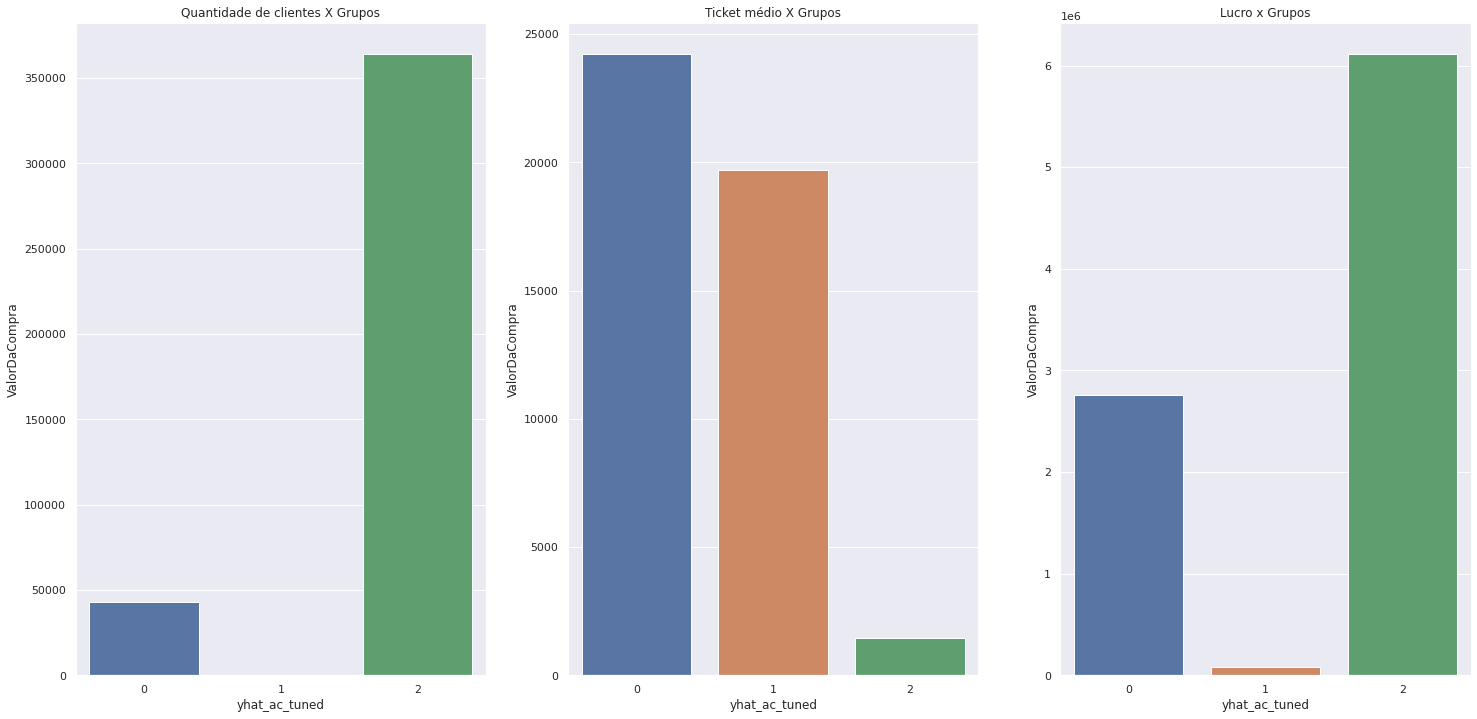

In [ ]:
#Quantidade de clientes X Grupos
plt.subplot(1,3,1)
aux=cluster[['ValorDaCompra','yhat_ac_tuned']].groupby(['yhat_ac_tuned']).count().reset_index()
ax=sns.barplot(x='yhat_ac_tuned',y='ValorDaCompra',data=aux)
ax.set_title('Quantidade de clientes X Grupos')

#Ticket médio X Grupos
plt.subplot(1,3,2)
aux=cluster[['ValorDaCompra','yhat_ac_tuned','IdCliente']].groupby(['yhat_ac_tuned','IdCliente']).sum().reset_index()
aux=aux.groupby(['yhat_ac_tuned']).mean().reset_index()
ax=sns.barplot(x='yhat_ac_tuned',y='ValorDaCompra',data=aux)
ax.set_title('Ticket médio X Grupos')

#Lucro x Grupos
plt.subplot(1,3,3)
aux=cluster[['ValorDaCompra','yhat_ac_tuned','IdCliente']].groupby(['yhat_ac_tuned']).sum().reset_index().head()
ax=sns.barplot(x='yhat_ac_tuned',y='ValorDaCompra',data=aux)
ax.set_title('Lucro x Grupos')

##7.2.Machine Learning Performance

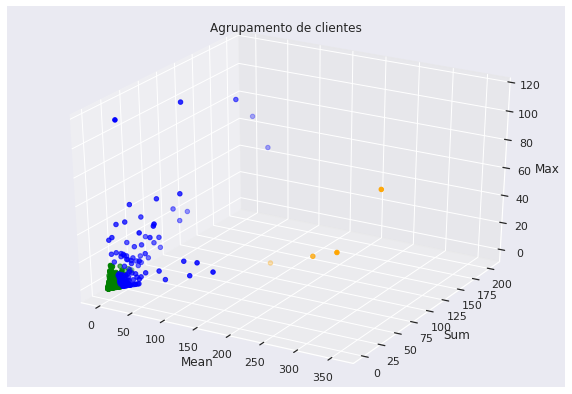

In [ ]:
# Creating dataset
aux=df_performance[['Mean','Sum','Max','yhat_ac_tuned']]

x1=aux[aux['yhat_ac_tuned']==0]['Mean']
y1=aux[aux['yhat_ac_tuned']==0]['Sum']
z1=aux[aux['yhat_ac_tuned']==0]['Max']

x2=aux[aux['yhat_ac_tuned']==1]['Mean']
y2=aux[aux['yhat_ac_tuned']==1]['Sum']
z2=aux[aux['yhat_ac_tuned']==1]['Max']

x3=aux[aux['yhat_ac_tuned']==2]['Mean']
y3=aux[aux['yhat_ac_tuned']==2]['Sum']
z3=aux[aux['yhat_ac_tuned']==2]['Max']

 
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(x1, y1, z1, color = "blue")
ax.scatter3D(x2, y2, z2, color = "orange")
ax.scatter3D(x3, y3, z3, color = "green")

ax.set_xlabel('Mean')
ax.set_ylabel('Sum')
ax.set_zlabel('Max')


plt.title("Agrupamento de clientes")
 
# show plot
plt.show()

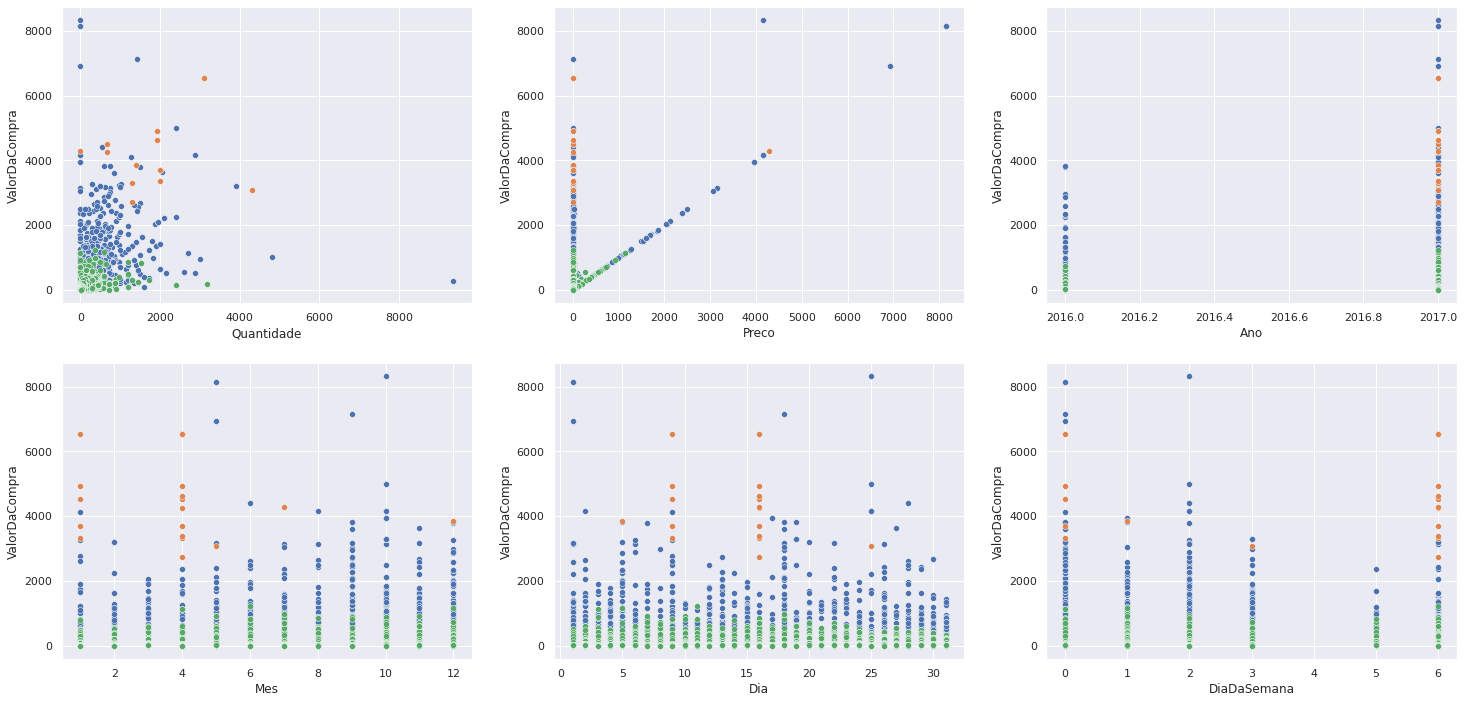

In [ ]:
#Quantidade
plt.subplot(2,3,1)
ax=sns.scatterplot(x='Quantidade',y='ValorDaCompra',data=cluster[cluster['yhat_ac_tuned']==0])
ax=sns.scatterplot(x='Quantidade',y='ValorDaCompra',data=cluster[cluster['yhat_ac_tuned']==1])
ax=sns.scatterplot(x='Quantidade',y='ValorDaCompra',data=cluster[cluster['yhat_ac_tuned']==2])


#Preco
plt.subplot(2,3,2)
ax=sns.scatterplot(x='Preco',y='ValorDaCompra',data=cluster[cluster['yhat_ac_tuned']==0])
ax=sns.scatterplot(x='Preco',y='ValorDaCompra',data=cluster[cluster['yhat_ac_tuned']==1])
ax=sns.scatterplot(x='Preco',y='ValorDaCompra',data=cluster[cluster['yhat_ac_tuned']==2])


#Ano
plt.subplot(2,3,3)
ax=sns.scatterplot(x='Ano',y='ValorDaCompra',data=cluster[cluster['yhat_ac_tuned']==0])
ax=sns.scatterplot(x='Ano',y='ValorDaCompra',data=cluster[cluster['yhat_ac_tuned']==1])
ax=sns.scatterplot(x='Ano',y='ValorDaCompra',data=cluster[cluster['yhat_ac_tuned']==2])


#Mes
plt.subplot(2,3,4)
ax=sns.scatterplot(x='Mes',y='ValorDaCompra',data=cluster[cluster['yhat_ac_tuned']==0])
ax=sns.scatterplot(x='Mes',y='ValorDaCompra',data=cluster[cluster['yhat_ac_tuned']==1])
ax=sns.scatterplot(x='Mes',y='ValorDaCompra',data=cluster[cluster['yhat_ac_tuned']==2])


#Dia
plt.subplot(2,3,5)
ax=sns.scatterplot(x='Dia',y='ValorDaCompra',data=cluster[cluster['yhat_ac_tuned']==0])
ax=sns.scatterplot(x='Dia',y='ValorDaCompra',data=cluster[cluster['yhat_ac_tuned']==1])
ax=sns.scatterplot(x='Dia',y='ValorDaCompra',data=cluster[cluster['yhat_ac_tuned']==2])


#DiaDaSemana
plt.subplot(2,3,6)
ax=sns.scatterplot(x='DiaDaSemana',y='ValorDaCompra',data=cluster[cluster['yhat_ac_tuned']==0])
ax=sns.scatterplot(x='DiaDaSemana',y='ValorDaCompra',data=cluster[cluster['yhat_ac_tuned']==1])
ax=sns.scatterplot(x='DiaDaSemana',y='ValorDaCompra',data=cluster[cluster['yhat_ac_tuned']==2])


#8.0. PASSO 8 - REPORT

In [ ]:
cluster['yhat_ac_tuned']=cluster['yhat_ac_tuned'].apply(lambda x: 'Insiders' if x==0 else x)

### 1 - Quem são as pessoas elegíveis para participar do programa de Insiders ?


In [ ]:
cluster[cluster['yhat_ac_tuned']=='Insiders']['IdCliente'].unique()

array(['12415.0', '12435.0', '12454.0', '12503.0', '12536.0', '12539.0',
       '12557.0', '12603.0', '12678.0', '12744.0', '12748.0', '12755.0',
       '12757.0', '12798.0', '12823.0', '12830.0', '12901.0', '12908.0',
       '12917.0', '12931.0', '12939.0', '12980.0', '13027.0', '13089.0',
       '13113.0', '13154.0', '13225.0', '13270.0', '13452.0', '13631.0',
       '13694.0', '13777.0', '13848.0', '13868.0', '13953.0', '14031.0',
       '14045.0', '14088.0', '14096.0', '14101.0', '14145.0', '14156.0',
       '14213.0', '14298.0', '14424.0', '14566.0', '14603.0', '14607.0',
       '14646.0', '14887.0', '14911.0', '15061.0', '15098.0', '15171.0',
       '15299.0', '15311.0', '15369.0', '15389.0', '15442.0', '15502.0',
       '15524.0', '15581.0', '15649.0', '15769.0', '15797.0', '15802.0',
       '15838.0', '16000.0', '16013.0', '16029.0', '16041.0', '16182.0',
       '16210.0', '16308.0', '16333.0', '16532.0', '16671.0', '16684.0',
       '16692.0', '16698.0', '16716.0', '16737.0', 

### 2 - Quantos clientes farão parte do grupo?

In [ ]:
len(cluster[cluster['yhat_ac_tuned']=='Insiders']['IdCliente'].unique())

114

### 3 - Quais as principais características desses clientes ?

In [ ]:
aux1=cluster[['IdCliente','yhat_ac_tuned','Produto','Quantidade','Preco','Pais','Ano','DiaDaSemana','ValorDaCompra']]

Text(0.5, 1.0, 'Produtos mais procurados dos Inseders')

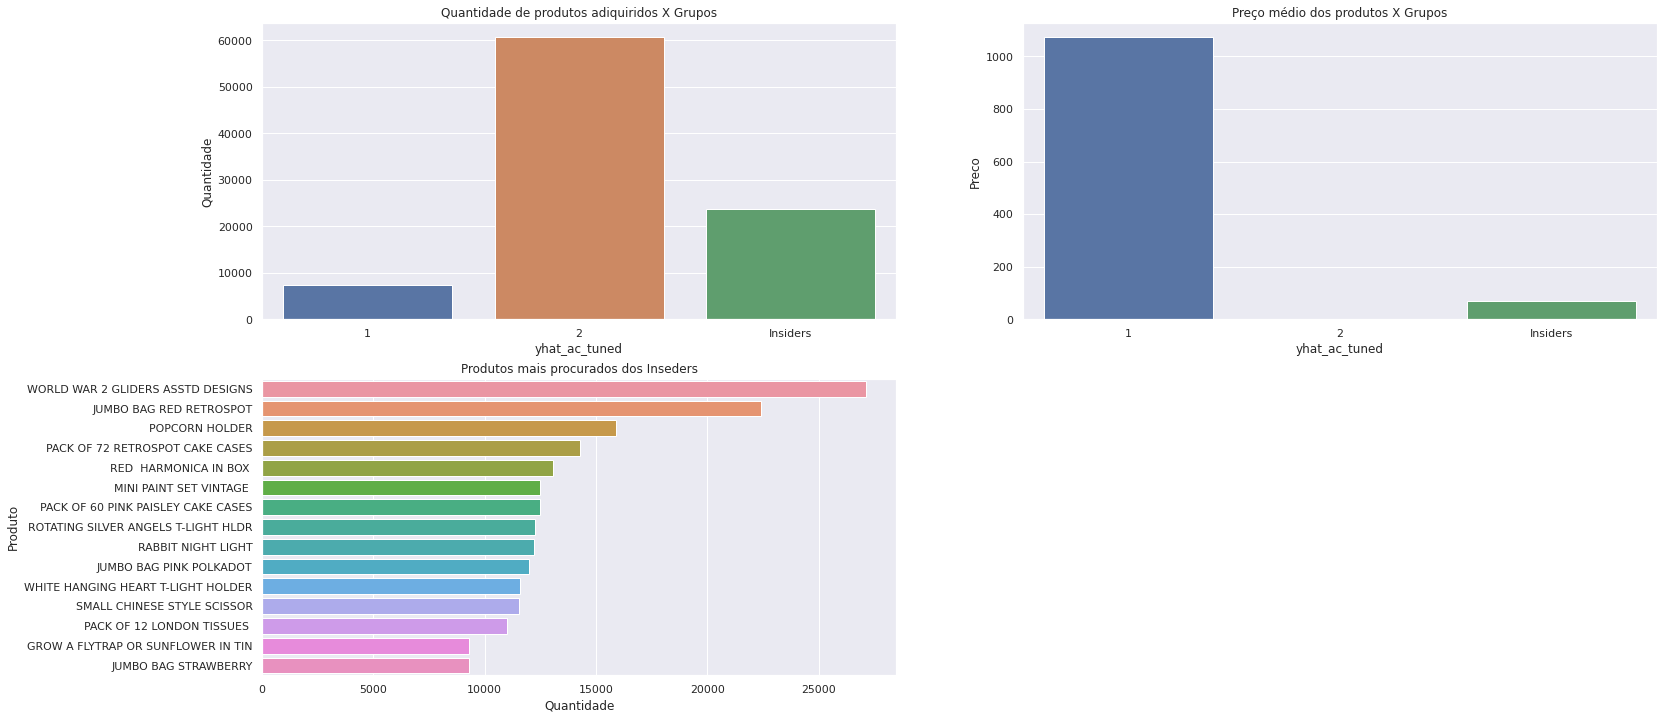

In [ ]:
plt.subplot(2,2,1)
aux2=aux1[['IdCliente','yhat_ac_tuned','Quantidade']].groupby(['yhat_ac_tuned','IdCliente']).mean().reset_index()
aux2=aux2.groupby(['yhat_ac_tuned']).sum().reset_index()
ax=sns.barplot(x='yhat_ac_tuned',y='Quantidade',data=aux2)
ax.set_title('Quantidade de produtos adiquiridos X Grupos')

plt.subplot(2,2,2)
aux2=aux1[['IdCliente','yhat_ac_tuned','Preco']].groupby(['yhat_ac_tuned','IdCliente']).mean().reset_index()
aux2=aux2.groupby(['yhat_ac_tuned']).mean().reset_index()
ax=sns.barplot(x='yhat_ac_tuned',y='Preco',data=aux2)
ax.set_title('Preço médio dos produtos X Grupos')


plt.subplot(2,2,3)
aux=aux1[['yhat_ac_tuned','Produto','Quantidade']].groupby(['yhat_ac_tuned','Produto']).sum().reset_index()
aux=aux[aux['yhat_ac_tuned']=='Insiders'].sort_values('Quantidade',ascending=False).head(15)
ax=sns.barplot(y='Produto',x='Quantidade',data=aux)
ax.set_title('Produtos mais procurados dos Inseders')

Text(0.5, 1.0, 'Grupo 2')

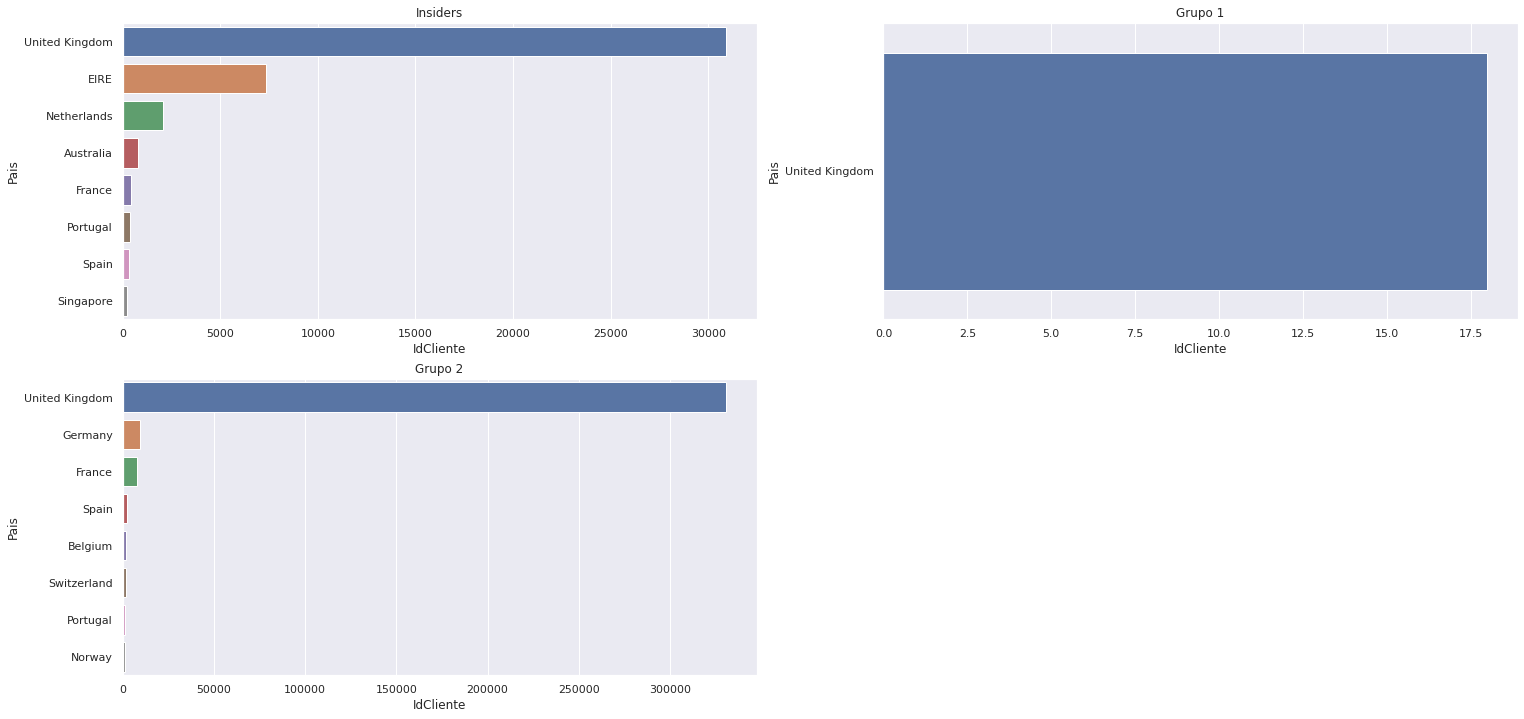

In [ ]:
aux=aux1[['IdCliente','yhat_ac_tuned','Pais']]
aux=aux.groupby(['yhat_ac_tuned','Pais']).count().reset_index()

plt.subplot(2,2,1)
ax=sns.barplot(y='Pais',x='IdCliente',data=aux[aux['yhat_ac_tuned']=='Insiders'].sort_values('IdCliente',ascending=False).head(8))
ax.set_title('Insiders')

plt.subplot(2,2,2)
ax=sns.barplot(y='Pais',x='IdCliente',data=aux[aux['yhat_ac_tuned']==1].sort_values('IdCliente',ascending=False).head(8))
ax.set_title('Grupo 1')

plt.subplot(2,2,3)
ax=sns.barplot(y='Pais',x='IdCliente',data=aux[aux['yhat_ac_tuned']==2].sort_values('IdCliente',ascending=False).head(8))
ax.set_title('Grupo 2')

Text(0.5, 1.0, 'Grupo 2')

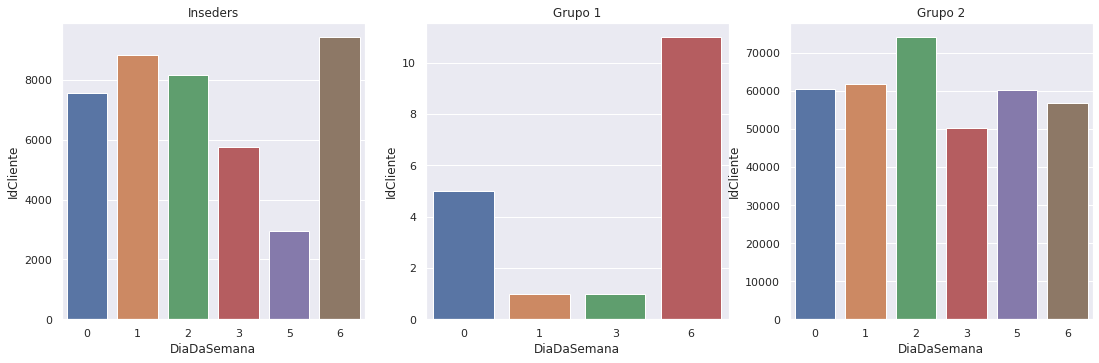

In [ ]:
aux2=aux1[['IdCliente','yhat_ac_tuned','DiaDaSemana']].groupby(['yhat_ac_tuned','DiaDaSemana']).count().reset_index()

plt.subplot(2,4,1)
ax=sns.barplot(x='DiaDaSemana',y='IdCliente',data=aux2[aux2['yhat_ac_tuned']=='Insiders'])
ax.set_title('Inseders')

plt.subplot(2,4,2)
ax=sns.barplot(x='DiaDaSemana',y='IdCliente',data=aux2[aux2['yhat_ac_tuned']==1])
ax.set_title('Grupo 1')

plt.subplot(2,4,3)
ax=sns.barplot(x='DiaDaSemana',y='IdCliente',data=aux2[aux2['yhat_ac_tuned']==2])
ax.set_title('Grupo 2')

### 4 - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?


In [ ]:
aux=cluster[['yhat_ac_tuned','ValorDaCompra']].groupby(['yhat_ac_tuned']).sum().reset_index()
aux['Percentual']=(aux['ValorDaCompra']*100)/aux['ValorDaCompra'].sum()
aux

,yhat_ac_tuned,ValorDaCompra,Percentual
0,1,78777.330,0.880
1,2,6113089.024,68.276
2,Insiders,2761637.240,30.844


### 5 - Qual a expectativa de faturamento desse grupo para os próximos 6 meses ?


Valor esperado nos próximos 6 meses R$ : 1008434.67


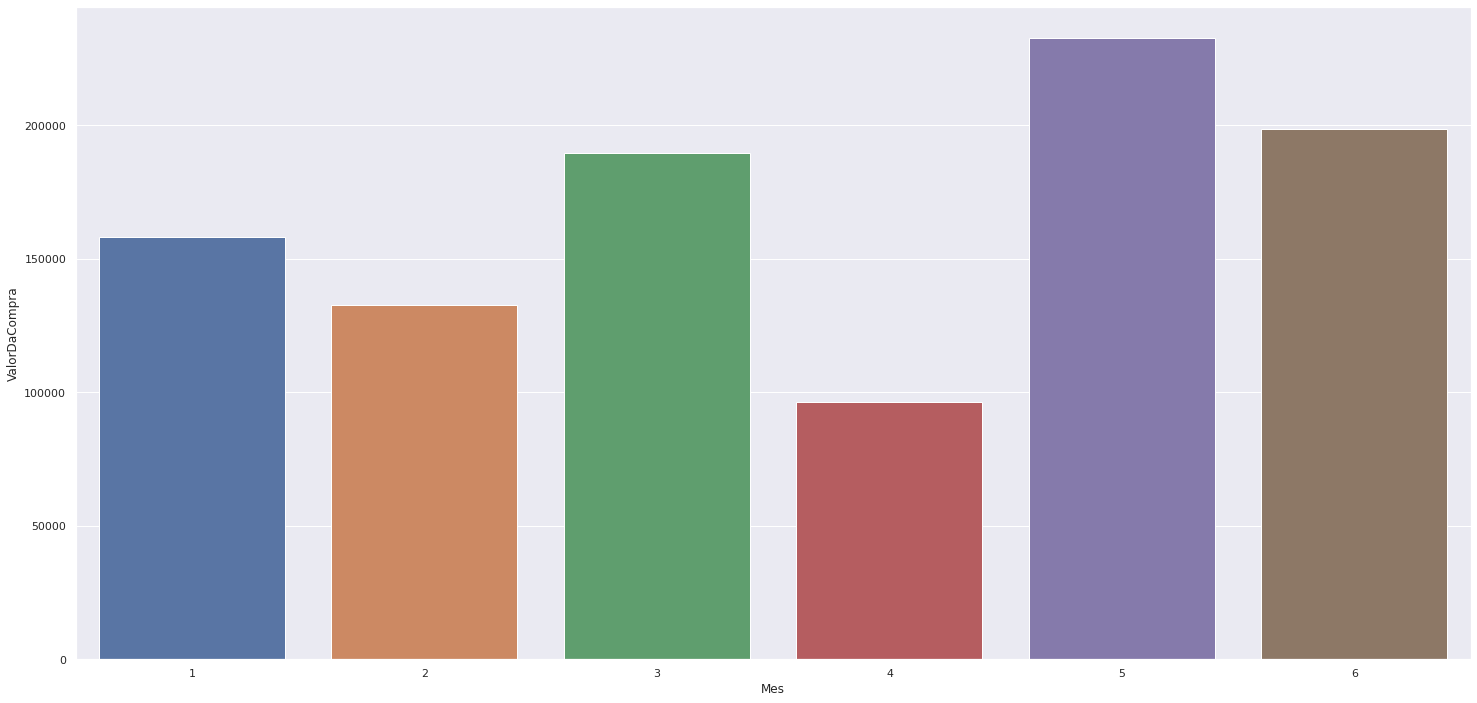

In [ ]:
aux=cluster[cluster['yhat_ac_tuned']=='Insiders']
aux=aux[aux['Ano']==2017]
aux=aux[['ValorDaCompra','Mes']].groupby('Mes').sum().reset_index()
sns.barplot(x='Mes',y='ValorDaCompra',data=aux[aux['Mes']<=6])
print('Valor esperado nos próximos 6 meses R$ : {}'.format(round(aux.head(6).sum()[1],2)))

### 6 - Quais as condições para uma pessoa ser elegível ao Insiders ?


In [ ]:
aux=cluster[(cluster['Ano']==2017) & (cluster['yhat_ac_tuned']=='Insiders')]
aux=aux[['IdCliente','ValorDaCompra']].groupby(['IdCliente']).sum().reset_index()
Valor_medio_gasto_em_2017=aux['ValorDaCompra'].mean()
print('Ter gasto na loja R$ {} no ano de 2017.'.format(round(Valor_medio_gasto_em_2017,2)))

Ter gasto na loja R$ 23389.23 no ano de 2017.


###7 - Quais as condições para uma pessoa ser removida do Insiders ?


In [ ]:
aux=cluster[(cluster['yhat_ac_tuned']=='Insiders')&(cluster['Mes']<=6)].groupby('IdCliente').sum().reset_index()
print('Ter gasto menos de R$ {} em compras nos próximos 6 meses.'.format(round(aux['ValorDaCompra'].mean(),2)))

Ter gasto menos de R$ 12005.17 em compras nos próximos 6 meses.


### 8 - Qual a garantia que o programa Insiders é melhor que o restante da base ?

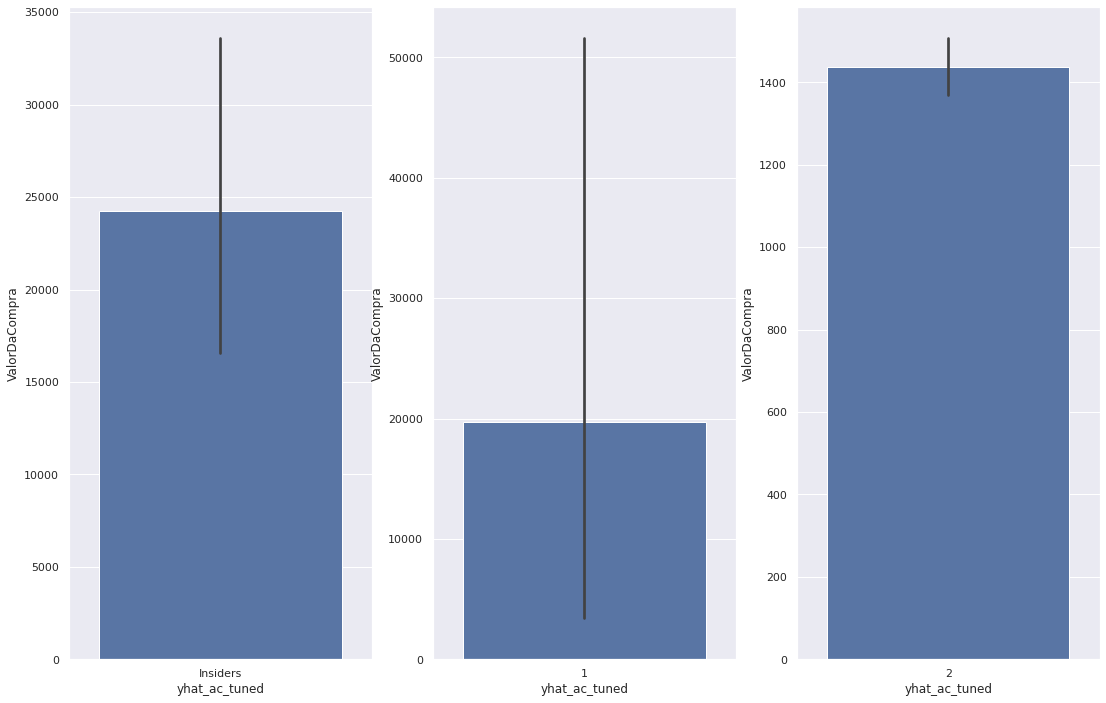

In [ ]:
aux=cluster[['IdCliente','yhat_ac_tuned','ValorDaCompra']].groupby(['yhat_ac_tuned','IdCliente']).sum().reset_index()

plt.subplot(1,4,1)
ax=sns.barplot(y='ValorDaCompra',x='yhat_ac_tuned',data=aux[aux['yhat_ac_tuned']=='Insiders'])

plt.subplot(1,4,2)
ax=sns.barplot(y='ValorDaCompra',x='yhat_ac_tuned',data=aux[aux['yhat_ac_tuned']==1])

plt.subplot(1,4,3)
ax=sns.barplot(y='ValorDaCompra',x='yhat_ac_tuned',data=aux[aux['yhat_ac_tuned']==2])

###9 - Quais ações o time de marketing pode realizar para aumentar o faturamento?




1.   Desconto e promoções nos produtos mais procurados.
2.   Intensificar a propaganda nos países da EIRE, Netherlands, Autralia e Portugal, France.
3.  Promover promoções relâmpago  nas terças e domingo.




